# Solving systems of linear equations

In this chapter we'll see how to recognize problems in which you can apply linear algebra to find the solution to a certain computational question.

Those are known as *systems of linear equations*. These problems are about finding points where lines, planes, or their higher dimensional analogies intersect. One example is the famous math problem about car s leaving two locations at different speeds and finding where they meet.

Those type of problems show up very frequently as in the Asteroids game in which you need to use linear equations to:
+ identify when the laser hits an asteroid &mdash; find whether the line defining the laser beam intersect with the line segments outlining the asteroids. If they do, the asteroid should be destroyed.
+ identify if an asteroid hits the spaceship &mdash; find whether any of the asteroids' segments intersect with the segments defining the spaceship.


## Designing an arcade game

We'll start with a simplified version of the asteroids game where the ship and asteroids are static.

### Modeling the game

In this section we display the spaceship and the asteroids as polygons in the game. We model these as collections of vectors.

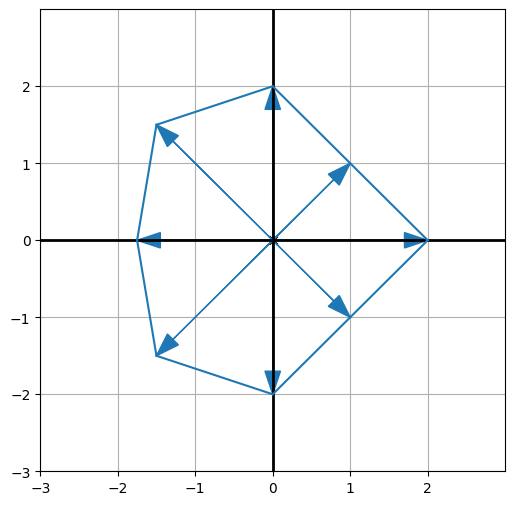

In [6]:
from vec2d.graph import Arrow, Segment, Colors, draw

asteroid_points = [(2, 0), (1, 1), (0, 2), (-1.5, 1.5), (-1.75, 0), (-1.5, -1.5), (0, -2), (1, -1)]

draw(
    *[Arrow(tip, color=Colors.BLUE) for tip in asteroid_points],
    *[Segment(asteroid_points[i], asteroid_points[(i + 1) % len(asteroid_points)]) for i in range(len(asteroid_points))]
)

The asteroid and spaceship will move (*translate*) and rotate as it travels through space, but its shape will remain the same. Thus, to represent these shapes in the game we'll need:
+ the defining vectors/points of the shape
+ its current (x, y) position
+ its current rotation angle

Therefore:

```python
class PolygonModel:
  def __init__(self, points):
    self.points = points
    self.rotation_angle = 0
    self.x = 0
    self.y = 0
```

| NOTE: |
| :---- |
| The source code for the basis of the game is found in [Asteroids: base](../../02_mini-projects/13-asteroids_base/). |

Thus when a shape (either an asteroid or the spaceship) moves we will apply the translation to change the `self.x` and `self.y`, and the rotation to `self.rotation_angle`.

We can subclass `PolygonModel` to represent the spaceship with a `Ship(PolygonModel)` class:

```python
class Ship(PolygonModel):
    def __init__(self) -> None:
        super().__init__([(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)])
```

We can do something similar for the asteroid. We can initialize it with a random number of sides between 5 and 9. We use a simple way involving polar coordinates to make the polygon defining the asteroid to be closed:

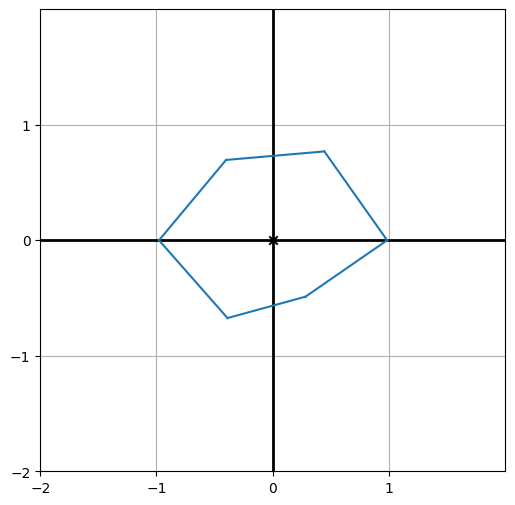

In [12]:
from math import pi
from vec2d.graph import Polygon
from vec2d.math import to_cartesian
from random import randint, uniform

sides = randint(5, 9)
points_polar = [(uniform(0.5, 1), 2 * pi * n / sides) for n in range(sides)]
points_cartesian = [to_cartesian(point_polar) for point_polar in points_polar]

draw(
    Polygon(*points_cartesian)
)



### Rendering the game

For the initial state of the game, we need a ship (which we can iniatilly place at the center of the screen), and a few asteroids that should be randomly spread out over the screen.

That initial state can be coded as:

```python
ship = Ship()

asteroid_count = 10
asteroids = [Asteroid() for _ in range(asteroid_count)]

for asteroid in asteroids:
  ast.x = randint(-9, 9)
  ast.y = randint(-9, 9)
```

This will render something like:

![Asteroid initial state vec2d](pics/asteroids-vec2d.png)

Obviously, rendering the game using our Matplotlib backend is not our goal. Instead, we can use PyGame's built-in 2D graphics engine.

PyGame will allow us to define a screen of agiven size, for example 400x400 pixel screen. Also, PyGame's built-in 2D engine places the `(0, 0)` coordinate in the top-left corner of the window, and the `(400, 400)` on the bottom right.

As a result, we need to do a mapping between the Math-oriented polygon model definition and how we represent them in the PyGame's screen.

Our Math oriented model ranges from `(-10, 10)` to `(10, 10)`, as can be seen in the picture above. We need to build a function `to_pixels(x, y)` that maps the shape coordinates to PyGame's screen coordinates.

The functions that map $ x_{math} \Rightarrow x_{screen} $ and $ y_{math} \Rightarrow y_{screen} $, can be found by assuming those will be linear (and therefore of the form $ ax + b $). With just a couple of points each we can find the corresponding coefficients.

For $ x $:

$
x_{math} = -10 \Rightarrow x_{screen} = 0 \\
x_{math} = 10 \Rightarrow x_{screen} = 400 \\
\begin{cases}
-10 \cdot a + b = 0 \\
10 \cdot a + b = 400 \\
\end{cases}
$

Which give us $ 20 \cdot x + 200 $.

Similarly for y:

$
y_{math} = 10 \Rightarrow y_{screen} = 0 \\
y_{math} = -10 \Rightarrow y_{screen} = 400 \\
\begin{cases}
-10 \cdot a + b = 0 \\
10 \cdot a + b = 400 \\
\end{cases}
$

Which give us $ -20 \cdot y + 200 $.

Thus:

In [ ]:
def to_pixels(x, y):
    x_screen = 20 * x + 200
    y_screen = -20 * y + 200
    return (x_screen, y_screen)

Another optimization we can do is enhance the `PolygonModel` class with a `transformed()` method that will give us the polygon's coordinates after having translated and rotated them in the Math coordinate system:

```python
class PolygonModel:
...
    def transformed(self):
        return translate((self.x, self.y), self.points)
```


By doing so, the initial state on the PyGame system will be achievable by simply doing:

```python
def draw_poly(screen, polygon_model, color=GREEN):
    pixel_points = [to_pixels(x, y) for x, y in polygon_model.transformed()]
    pygame.draw.aalines(screen, color, True, pixel_points)
```

![Asteroids: PyGame](pics/asteroids-pygame.png)

### Shooting the laser

In the 2D world we've modeled, the laser beam should be a line segment starting at the transformed tip of the spaceship and extending in the direction the ship is pointed.

We can make sure it reaches the end of the screen by making it sufficiently long.

As only the Ship can shoot, we can define a `laser_segment` method on the `Ship` class itself.

The method returns the coordinates in the Math model (that is, within the $ -10 \le x \le 10 $, $ -10 \le y \le 10 $ canvas) of a segment that goes from the tip of the ship, to a point that we're sure it sits offscreen.

```python
def laser_segment(self):
    max_width = self.X_MAX - self.X_MIN
    max_height = self.Y_MAX - self.Y_MIN

    max_dist = sqrt(max_width ** 2 + max_height ** 2)
    ship_tip, *_ = self.transformed()
    _, ship_tip_polar_angle = to_polar(ship_tip)
    laser_tip = (max_dist, ship_tip_polar_angle)
    return (ship_tip, to_cartesian(laser_tip))
```

With this in place, we can start looking at what will happen when the laser segment hits an asteroid.

A simplistic, yet valid approach, is to enhance the `PolygonModel` with a `does_intersect(segment)` which returns true if the input segment intersects any segment of the given `PolygonModel`.

Then, in the game loop we check if any of the asteroids intersect with the laser that has been shot, and if it does, we remove the asteroid.

```python
  # Get the state of the keyboard keys
  keys = pygame.key.get_pressed()
  if keys[pygame.K_SPACE]:
      laser_shot = ship.laser_segment()
      draw_segment(screen, laser_shot)

      for asteroid in asteroids:
          if asteroid.does_intersect(laser_shot):
              asteroids.remove(asteroid)
```

We'll implement the `does_intersect` logic in the subsequent sections.

### Exercise

Finish the implementation of the `transformed()` method on the `PolygonModel` that returns the points of the model translated by the object's `x` and `y` attributes and rotated by its `rotation_angle` attribute.

The translation has already been implemented, so only the rotation needs to be added:

```python
def transformed(self):
    rotated_points = rotate(self.rotation_angle, self.points)
    return translate((self.x, self.y), rotated_points)
```

### Exercise

Write a function `to_pixels(x, y)` that takes a pair of x- and y- coordinates in the square where $ -10 < x < 10 $ and $ -10 < y < 10 $ (Math model) and maps to the corresponding PyGame x and y pixel coordinates (Game model), each ranging from 0 to 400.

Can you generalize the solution so that it works for any Math and Game models?

We already elaborated in the solution for the Math model ranging from $ -10 < x < 10 $ and $ -10 < y < 10 $ to `(0, 0)` - `(400, 400)`.

```python
def to_pixels(x, y):
    x_screen = 20 * x + 200
    y_screen = -20 * y + 200
    return (x_screen, y_screen)
```

To make it generic, you just need to use the same approach, but using generic values for:

Math model:

$
x_{math-min}, x_{math-max} \\
y_{math-min}, y_{math-max}
$

Math model:

$
x_{scr-min}, x_{scr-max} \\
y_{scr-min}, y_{scr-max}
$

Then:

$
x_{math} = x_{math-min} \Rightarrow x_{screen} = x_{scr-min} \\
x_{math} = x_{math-max} \Rightarrow x_{screen} = x_{scr-max} \\
\begin{cases}
x_{math-min} \cdot a + b = x_{scr-min} \\
x_{math-max} \cdot a + b = x_{scr-max} \\
\end{cases}
$

Similarly for y:

$
y_{math-min} \cdot a + b = y_{scr-min} \\
y_{math-max} \cdot a + b = y_{scr-max} \\
\begin{cases}
y_{math-min} \cdot a + b = y_{scr-min} \\
y_{math-max} \cdot a + b = y_{scr-max} \\
\end{cases}
$

Solving those pair or systems of linear equations give us the generic solution.

## Finding intersection points of lines

Now, we need to find a way to identify when the laser beam hits an asteroid.

The approach will be to iteratively focus on each asteroid, and within an asteroid, focus on each segment defining the asteroid and find whether the laser beam and the segment intersects.

Finding whether two lines in the 2D plane intersect, means solving a system of linear equations in two variables.

The following picture illustrates the idea:

![Finding the intersection](pics/asteroids-intersection.png)

We will try and find the intersection point, and if found, we will need to see if it lies within the bounds of both segments (as we could find an intersection point outside of the asteroid segment).

### Choosing the right formula for a line

If we start with a line through the origin (e.g., $ t \cdot \vec{v} $) and translate by another vector $ \vec{u} $, we can get any possible line.

The points on this line will have the form $ \vec{u} + t \cdot \vec{v} $ for some scalar $ t $, and some vectors $ \vec{u} $ and $ \vec{v} $.

The following picture illustrate it with an example:

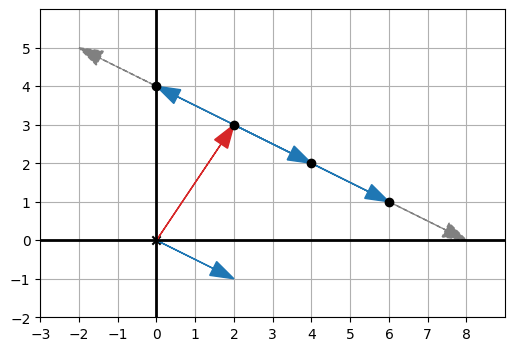

In [10]:
from vec2d.graph import draw, Arrow, Colors, LineStyles, Points
from vec2d.math import scale, add

u = (2, 3)
v = (2, -1)

draw(
    Arrow(u, color=Colors.RED),
    Arrow(v, color=Colors.BLUE),
    Arrow(add(u, scale(-2, v)), u, color=Colors.GRAY, linestyle=LineStyles.DASHED),
    Arrow(add(u, scale(3, v)), u, color=Colors.GRAY, linestyle=LineStyles.DASHED),
    Arrow(add(u, scale(-1, v)), u, color=Colors.BLUE),
    Arrow(add(u, scale(1, v)), u, color=Colors.BLUE),
    Arrow(add(u, scale(2, v)), u, color=Colors.BLUE),

    Points(
        add(u, scale(-1, v)),
        add(u, scale(0, v)),
        add(u, scale(1, v)),
        add(u, scale(2, v)),
    ),

)

See how the expression $ \vec{u} + t \cdot \vec{v} $ ends up describing a line that doesn't pass through the origin.

As a matter of fact, any line can be described with that expression for some selection of vectors $ \vec{u} $ and $ \vec{v} $ and some scalar $ t $.

Sometimes that expression is sometimes written as:

$
\vec{r}(t) = \vec{u} + t \cdot \vec{v}
$

that indicates that this line is a vector valued function $ \vec{r} $ of the scalar parameter $ t $.

The advantage of that formula is that it's very simple to get it if you have two points that define the line.

Consider that you have two points $ u $ and $ w $, and we want to find the straight line that goes through those points:

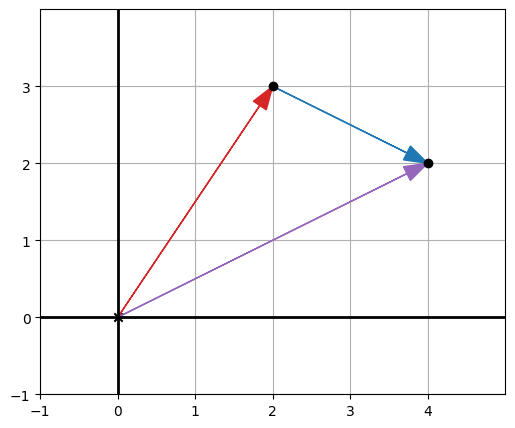

In [12]:
from vec2d.graph import Arrow, Colors, LineStyles, draw, Points
from vec2d.math import add

u = (2, 3)
w = (4, 2)

draw(
    Arrow(u, color=Colors.RED),
    Arrow(w, color=Colors.PURPLE),
    Arrow(w, u, color=Colors.BLUE),
    Points(u, w)
)


$ \vec{u} $ (the red vector), can be interpreted as the translation vector, and $ \vec{w} - \vec{u} $ as the vector that gets scaled in the formula above:

+ when t = 0, $ \vec{r}(0) = \vec{u} + 0 \cdot (\vec{w} - \vec{u}) = \vec{u} $, the red vector.
+ when t = 1, $ \vec{r}(0) = \vec{u} + 1 \cdot (\vec{w} - \vec{u}) = \vec{w} $, the purple vector.

Thus, given $ \vec{u} $ and $ \vec{w} $, the formula for the line that connects them is $ \vec{r}(t) = \vec{u} + t \cdot (\vec{w} - \vec{u}) $.


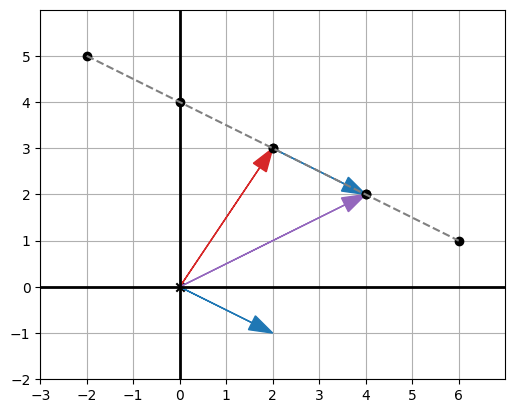

In [19]:
from vec2d.graph import Arrow, Colors, LineStyles, draw, Points, Segment
from vec2d.math import add, scale, subtract

u = (2, 3)
w = (4, 2)

draw(
    Segment(add(u, scale(-2, subtract(w, u))), add(u, scale(2, subtract(w, u))), color=Colors.GRAY, linestyle=LineStyles.DASHED),
    Arrow(u, color=Colors.RED),
    Arrow(w, color=Colors.PURPLE),
    Arrow(w, u, color=Colors.BLUE),
    Arrow(subtract(w, u), color=Colors.BLUE),
    Points(u, w, *[add(u, scale(t, subtract(w, u))) for t in range(-2, 3)])
)


The formula $ \vec{r}(t) = \vec{u} + t \cdot (\vec{w} - \vec{u}) $ also has its downside, as there are multiple ways to write the same line in this form. The extra parameter $ t $ also makes it harder when using the formula to solve equations.

Thus, we need to find some alternative formulas that will suit our goal better.

The formula you would recall from your high school days is $ y = m \cdot x + n $.

This formula makes it very easy to graph a line, because it gives you a y-coordinate as a function of the x-coordinate: you take a bunch of x values, apply the formula and you have the line.

However, it also has a major drawback, as it cannot be used to draw vertical lines such as $ \vec{r}(t) = (3, 0) + t \cdot (0, 1) $. This is the line of vectors where $ x = 3 $.

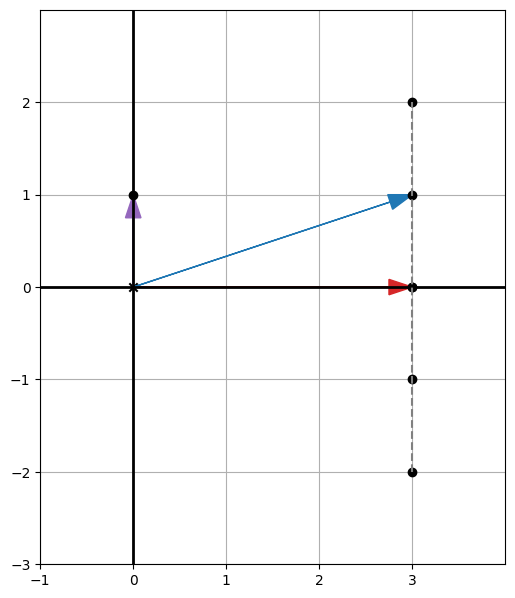

In [25]:
from vec2d.graph import Arrow, Colors, LineStyles, draw, Points, Segment
from vec2d.math import add, scale, subtract

u = (3, 0)
v = (0, 1)

draw(
    Segment(add(u, scale(-2, v)), add(u, scale(2, v)), color=Colors.GRAY, linestyle=LineStyles.DASHED),
    Arrow(u, color=Colors.RED),
    Arrow(v, color=Colors.PURPLE),
    Arrow(add(u, v), color=Colors.BLUE),
    Points(u, w, *[add(u, scale(t, v)) for t in range(-2, 3)])
)


Because of this major drawback (not being able to represent vertical lines) of $ y = m \cdot x + n $, we need to revert back to our parametric formula for the line $ \vec{r}(t) = \vec{u} + t \cdot \vec{v} $.

However, it would be great to have a formula with no extra parameter $ t $ that would represent any line.

Let's consider now the expression $ ax + by = c $.

This formula has no extra parameter $ t $, and the set of points that satisfy that expression is a straight line.

For example, let's consider $ x + 2y = 8 $.

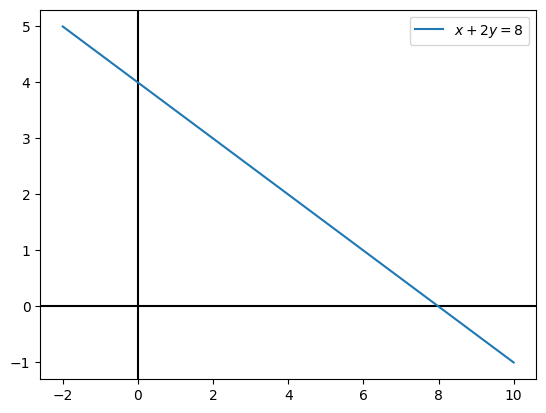

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return (8 - x) / 2

xs = np.linspace(-2, 10)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
fn_name = r"$ x + 2y = 8 $"
ys = [f(x) for x in xs]
plt.plot(xs, ys, label=fn_name)
ax.legend()
plt.show()

And the form $ ax + by = c $ can also represent vertical lines, as $ x = 3 $ is the same as $ 1 \cdot x + 0 \cdot y = 3 $.

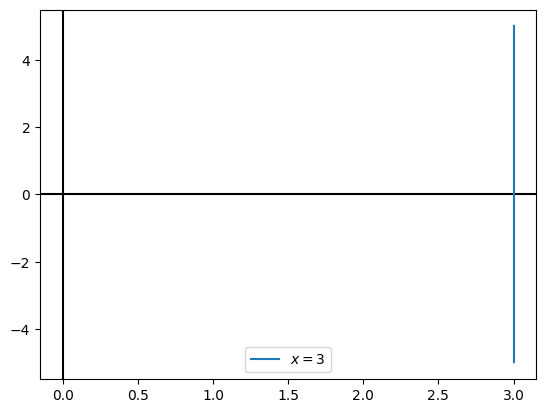

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def f(y):
    return 3

ys = np.linspace(-5, 5)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
fn_name = r"$ x = 3 $"
xs = [f(y) for y in ys]
plt.plot(xs, ys, label=fn_name)
ax.legend()
plt.show()

In summary, the formula $ ax + by = c $ has no extra parameters and can represent any line.

Any equation representing a line is called a linear equation, and the formula $ ax + by = c $ is called the *standard form* for a linear equation. That form serves our purposes better than the *parametric* formula, or the $ y = m \cdot x + n $ formula.

### Finding the standard form equation for a line

Let's systematize finding the standard form for linear equations.

Consider the following asteroid, for which we will try to find the standard form for the segment defined by $ (1, 5) $ and $ (2, 3) $.

| NOTE: |
| :---- |
| vec2d versions <= 0.2.2 did not correctly handled the alpha blending when rendering polygons. The conda environment was updated to `vec2d@0.2.3` doing: `pip install vec2d==0.2.3`. |

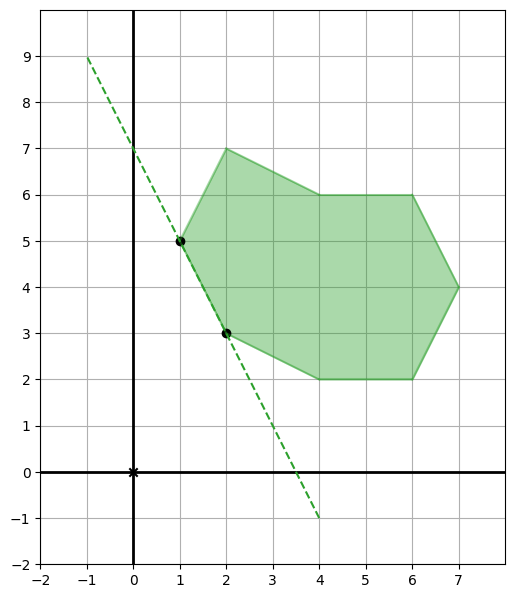

In [7]:
from vec2d.graph import draw, Polygon, Segment, Points, Colors, LineStyles
from vec2d.math import add, subtract, scale

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

p1 = (1, 5)
p2 = (2, 3)

draw(
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Points(p1, p2),
    Segment(add(p1, scale(-2, subtract(p2, p1))), add(p1, scale(3, subtract(p2, p1))), color=Colors.GREEN, linestyle=LineStyles.DASHED)
)

We can assume $ \vec{u} = (1, 5) $, $ \vec{w} = (2, 3) $.

Then $ \vec{w} - \vec{u} = (2, 3) - (1, 5) = (1, -2) $, which is parallel to the dashed line pictured above.

Because both $ (1, 5) $ and $ (2, 3) $ lie on the line, we can use our *parametric formula* for the line:

$
\vec{r}(t) = u + t \cdot (w - u) \\
\vec{r}(t) = (1, 5) + t \cdot (1, -2) \\
$

Now we need to do some algebra to get rid of the $ t $. If we consider $ (x, y) = \vec{r}(t) $, we'd have:

$
(x, y) = (1, 5) + t \cdot (1, -2) \\
\begin{cases}
x = 1 + t \\
y = 5 + t \cdot (-2) = 5 - 2 \cdot t \\
\end{cases}
$

Thus,

$
t = x - 1 \\
y = 5 - 2 \cdot (x - 1) = 5 -2x + 2 \Rightarrow 2x + y = 7
$

That is, the *standard form* for that equation describing the line that passes through $ (1, 5) $ and $ (2, 3) $ is $ 2x + y = 7 $

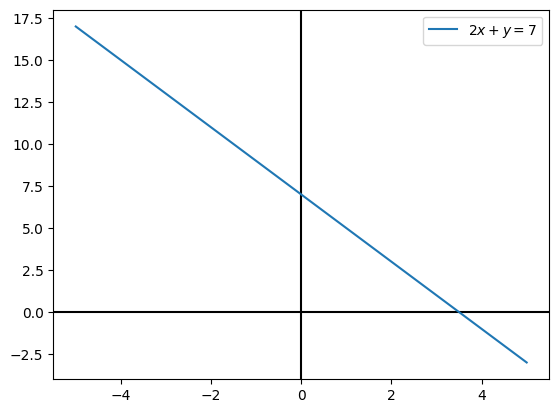

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 7 - 2 * x

xs = np.linspace(-5, 5)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
fn_name = r"$ 2x + y = 7 $"
ys = [f(x) for x in xs]
plt.plot(xs, ys, label=fn_name)
ax.legend()
plt.show()

This process isn't too hard, so now we need to find a way to make it more generic, so that we can automate it using Python.

In the general problem, we will be given two points: $ (x_1, y_1) $ and $ (x_2, y_2) $, and we need to find the the equation for the line that passes through those points in the standard form $ ax + by = c $.

As we did in the example, we start from the parametric formula for the line:

$
(x, y) = (x_1, y_1) + t \cdot (x_2 - x_1, y_2 - y_1)
$

This gives us a pair of equations:

$
\begin{cases}
x = x_1 + t \cdot (x_2 - x_1) \\
y = y_1 + t \cdot (y_2 - y_1) \\
\end{cases}
$

We can solve for $ t $ in one of the equations and substitute in the other to get rid of the $ t $:

$
t = \frac{x - x_1}{x_2 - x_1}
$

Then, when we substitute in the second equation:

$
y = y_1 + (\frac{x - x_1}{x_2 - x_1}) \cdot (y_2 - y_1) \\
y = y_1 + \frac{(x - x_1) \cdot (y_2 - y_1)}{x_2 - x_1} \\
y = y_1 + \frac{x \cdot y_2 - x \cdot y_1 - x_1 \cdot y_2 + x_1 \cdot y_1}{x_2 - x_1}
$



Thus,

$
(x_2 - x_1) \cdot y = y_1 \cdot (x_2 - x_1) + x \cdot y_2 - x \cdot y_1 - x_1 \cdot y_2 + x_1 \cdot y_1
$

If we keep calculating, to accommodate to the standard form:

$
(x_2 - x_1) \cdot y = y_1 \cdot (x_2 - x_1) + x \cdot ( y_2 - y_1) - x_1 \cdot y_2 + x_1 \cdot y_1 \\
x \cdot (y_2 - y_1) + y \cdot (x_1 - x_2) = x_1 \cdot y_2 - x_1 \cdot y_1 - y_1 \cdot x_2 + y_1 \cdot x_1
$

And we can simplify a little bit:

$
x \cdot (y_2 - y_1) + y \cdot (x_1 - x_2) = x_1 \cdot y_2 - x_1 \cdot y_1 - y_1 \cdot x_2 + y_1 \cdot x_1
$

Which leads to the standard form we were looking for:

$
(y_2 - y_1) \cdot x  + (x_1 - x_2) \cdot y = x_1 \cdot y_2 - x_2 \cdot y_1
$

Therefore, for any two given points $ (x_1, y_1) $ and $ (x_2, y_2) $, the equation that gives us the line that goes through those points can be written as $ ax + by = c $, where:

$
a = (y_2 - y_1) \\
b = (x_1 - x_2) \\
c = (x_1 \cdot y_2 - x_2 \cdot y_1)
$

Let's try that formula with our previous example:

$
P_1 = (2, 3), \; P_2 = (1, 5) \\
x_1 = 2, \; x_2 = 1, \; y_1 = 3, \; y_2 = 5 \\
$

Therefore:

$
a = 5 - 3 = 2 \\
b = 2 - 1 = 1 \\
c = 2 \cdot 5 - 1 \cdot 3 = 10 - 3 = 7
$

As a result, the standard form for the equation would be:

$
2x + y = 7
$

If we now apply it to the laser beam for the following situation of the ship.



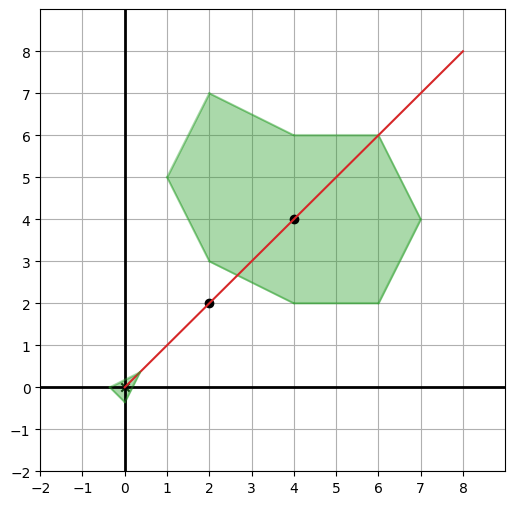

In [15]:
from math import pi
from vec2d.graph import draw, Polygon, Segment, Points, Colors, LineStyles
from vec2d.math import add, subtract, scale, rotate


asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]

p1 = (1, 5)
p2 = (2, 3)

draw(
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Segment((0, 0), (8, 8), color=Colors.RED),
    Points((2, 2), (4, 4)),
    Polygon(*rotate(pi / 4, ship_points), color=Colors.GREEN, fill=Colors.GREEN)

)

So the laser beam seems to go through $ (2, 2) $ and $ (4, 4) $. Therefore, the formula in the standard form for the laser beam line will be:

$
x_1 = 2, \; x_2 = 4, \; y_1 = 2, \; y_2 = 4 \\
$

And therefore:

$
a = (y_2 - y_1) = 2 \\
b = (x_1 - x_2) = -2 \\
c = (x_1 \cdot y_2 - x_2 \cdot y_1) = 2 \cdot 4 - 4 \cdot 2 = 0
$

Thus, the equation will be: $ x - y = 0 $.

In summary, we now possess a procedure to determine the equation for the asteroid segments and the laser beam, so we can decide whether the laser hits any of the asteroids segments by way of finding where the laser beam intersects the line defined by each of the asteroids.

### Linear equations in matrix notation

Let's begin by considering the situation depicted above:

We've found:
+ laser beam defined by $ x - y = 0 $
+ asteroid segment defined by $ x + 2y = 8 $ 


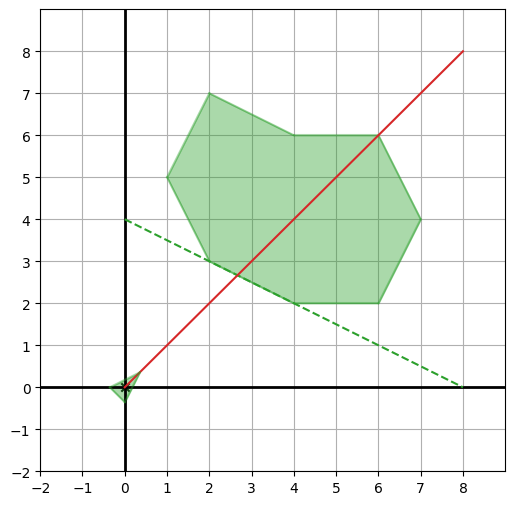

In [18]:
from math import pi
from vec2d.graph import draw, Polygon, Segment, Points, Colors, LineStyles
from vec2d.math import add, subtract, scale, rotate


asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]

p1 = (1, 5)
p2 = (2, 3)

def asteroid_segment(x):
    return (8 - x) / 2

draw(
    Segment((0, asteroid_segment(0)), (8, asteroid_segment(8)), color=Colors.GREEN, linestyle=LineStyles.DASHED),
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Segment((0, 0), (8, 8), color=Colors.RED),
    Polygon(*rotate(pi / 4, ship_points), color=Colors.GREEN, fill=Colors.GREEN)

)

We know that there're an intersection, and it falls in the segment range, so we should find that solution.

The first thing we need to do is write the two equations in a grid (as it's customary):

$
\begin{cases}
x - y = 0 \\
x + 2y = 8
\end{cases}
$

We can organize that system of linear equations into a single matrix equation:

$
x \cdot \begin{pmatrix}
1 \\
1 \\
\end{pmatrix} + y \cdot \begin{pmatrix}
-1 \\
2 \\
\end{pmatrix} = \begin{pmatrix}
0 \\
8 \\
\end{pmatrix}
$

And the expression above can also be written as a matrix multiplication:

$
\begin{pmatrix}
1 & -1 \\
1 & 2 \\
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
\end{pmatrix} = \begin{pmatrix}
0 \\
8 \\
\end{pmatrix}
$


When written in this way, we think of the problem as: what vector $ (x, y) $ is multiplied by the given matrix to yield $ (0, 8) $?

Thus, solving a system of linear equations is equivalent to finding a linear combination of some vectors that product another vector.

### Solving linear equations with NumPy

Python's NumPy library has a linear algebra module and a function that help us find the solution to systems of linear equations in the form:

$
\begin{pmatrix}
1 & -1 \\
1 & 2 \\
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
\end{pmatrix} = \begin{pmatrix}
0 \\
8 \\
\end{pmatrix}
$

Remember that finding the solution to that system, would mean finding the intersection between $ x - y = 0 $ and $ x - 2y = 8 $, which in turn will give tell us if the segment that represents the laser beam intersects with one of the segments of the asteroid in our game.

In [2]:
import numpy as np

matrix = np.array((
    (1, -1),
    (1, 2)
))
output = np.array((0, 8))

np.linalg.solve(matrix, output)

array([2.66666667, 2.66666667])

NumPy has found that the x- and y-coordinates of the intersection are $ (2.66666667, 2.66666667) $.

Let's confirm it looks about right by looking at the picture:

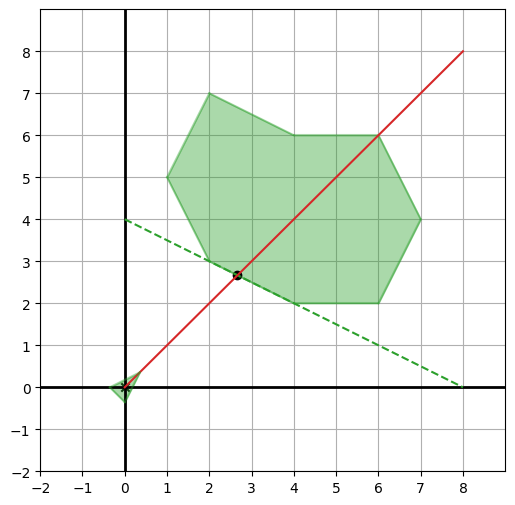

In [5]:
from math import pi
from vec2d.graph import draw, Polygon, Segment, Points, Colors, LineStyles
from vec2d.math import rotate

intersection_point = (2.66666667, 2.66666667)

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]

p1 = (1, 5)
p2 = (2, 3)

def asteroid_segment(x):
    return (8 - x) / 2

draw(
    Segment((0, asteroid_segment(0)), (8, asteroid_segment(8)), color=Colors.GREEN, linestyle=LineStyles.DASHED),
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Segment((0, 0), (8, 8), color=Colors.RED),
    Polygon(*rotate(pi / 4, ship_points), color=Colors.GREEN, fill=Colors.GREEN),
    Points(intersection_point)
)

It looks correct.

We can also confirm that the point `(2.66666667, 2.66666667)` lies on both lines by substituting it in both equations:

$
x - y = 2.66666667 - 2.66666667 = 0 \\
x + 2y = 2.66666667 + 2 \cdot 2.66666667 = 8.00000001
$

Similarly, the vector:
$ 
\begin{pmatrix}
2.66666667 \\
2.66666667 \\
\end{pmatrix}
$

is the one that satisfies the equation:

$
\begin{pmatrix}
1 & -1 \\
1 & 2 \\
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
\end{pmatrix} = \begin{pmatrix}
0 \\
8 \\
\end{pmatrix}
$

Thus, `numpy.linalg.solve` has allowed us to find a solution for one of the most important computational task in linear algebra:
> Given a matrix $ A $ and a vector $ \vec{w} $, find the vector such that $ A \vec{v} = \vec{w} $.

### Deciding whether the laser hits an asteroid

We know now of a function we can use to find out when our laser hits asteroids.

We had in our implementation a `does_intersect(self, segment)` in our `PolygonModel` class that required an implementation. The function should return `True` if the given segment intersects any of the segments that define the polygon.

For this, we need a few helper functions to facilitate the process. First, we need to convert the given segment (which represents the laser beam) and each of the polygon segments to linear equations in standard form.

Let's assume that we have that function already implemented:

```python
def standard_form(point_1, point_2):
  """
  Returns a tuple (a, b, c) representing the coefficients of the
  linear equation in standard form ax + by = c representing the
  straight line passing through the given points.
  """
```

Next, we will need a `intersection` function that will receive four points/vectors:

```python
def intersection(u1, u2, v1, v2):
  """
  Returns the intersection point (if found) of the lines defined by
  u1 and u2, and v1 and v2.
  """
```

Implementing that function is easy if we bank on `standard_form` and `numpy.linalg.solve`:

```python
def intersection(u1, u2, v1, v2):
  a1, b1, c1 = standard_form(u1, u2)
  a2, b2, c2 = standard_form(v1, v2)
  m = np.array(((a1, b1), (a2, b2)))
  c = np.array((c1, c2))
  return np.linalg.solve(m, c)
```

Note that `np.linalg.solve` might find a intersection point, but the intersection point could lie outside of any (or both) of the segments.

The following picture illustrates that situation, in which the straight lines representing an asteroid segment and the laser beam intersect but on a point outside of the asteroid:

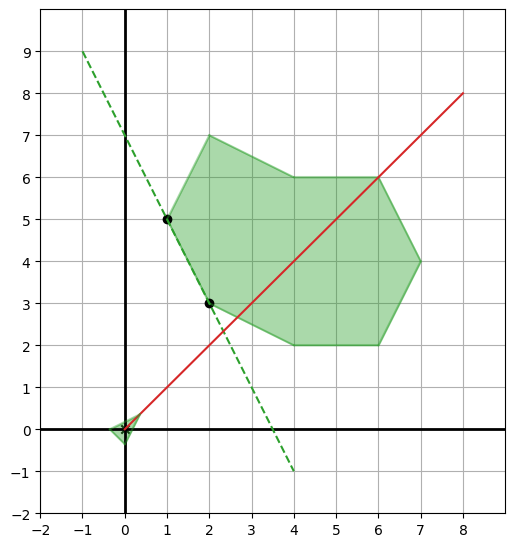

In [7]:
from vec2d.graph import draw, Polygon, Segment, Points, Colors, LineStyles
from vec2d.math import add, subtract, scale

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

p1 = (1, 5)
p2 = (2, 3)

ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]

def asteroid_segment(x):
    return (8 - x) / 2

draw(
    Segment(add(p1, scale(-2, subtract(p2, p1))), add(p1, scale(3, subtract(p2, p1))), color=Colors.GREEN, linestyle=LineStyles.DASHED),
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Segment((0, 0), (8, 8), color=Colors.RED),
    Polygon(*rotate(pi / 4, ship_points), color=Colors.GREEN, fill=Colors.GREEN),
    Points(p1, p2)
)

You see how the lines extending the segments intersect, but outside of the asteroid.

As a result, we do need an additional helper function that will check whether the segments (and not the lines extending the segments) intersect.

The best way to do so is by checking the distance between the intersection point and each of the points that define the segments.

You may recall from [01: Linear Algebra 2D: Subtraction, displacement, and distance](../01_linear-algebra-2d/01-linear-algebra-2d-concepts.ipynb#subtraction-displacement-and-distance) that the distance is the length of the displacement vector.

That is, the distance between two vectors is the length of the vector that results from subtracting one vector from another. As a result, the segments will intersect if the distance between the intersection point and each of the points:

```python
def do_segments_intersect(s1, s2):
  """
  Returns True if the segments defined by s1 and s2 intersect.
  s1 and s2 are a tuple of two elements, with each element being a point that define the segment.
  """
  u1, u2 = s1
  v1, v2 = s2
  d1, d2 = distance(*s1), distance(*s2)
  x, y = intersection(u1, u2, v1, v2)
  return (
    distance(u1, (x, y)) <= d1 and
    distance(u2, (x, y)) <= d1 and
    distance(v1, (x, y)) <= d2 and
    distance(v2, (x, y)) <= d2
  )
```

With all these helper functions in place, we can finally implement our `does_intersect` method, which should take care of all of the asteroid segments:

```python
def does_intersect(self, laser_segment):
    for segment in self.segments():
        if do_segments_intersect(segment, laser_segment):
            return True
    return False
```

### Identifying unsolvable systems

Not every system of linear equations in 2D can be solved. Some pairs of linear equations in 2D don't have unique solutions, and others don't have solutions at all.

If we pass NumPy a system of linear equations with no solution, we'll get an exception that we'll need to handle.

Those situations happen when we have a pair or parallel lines (they will never intersect), or lines that are the same despite having different equations (they will have infinite solutions).

Consider first the situation of two parallel lines:

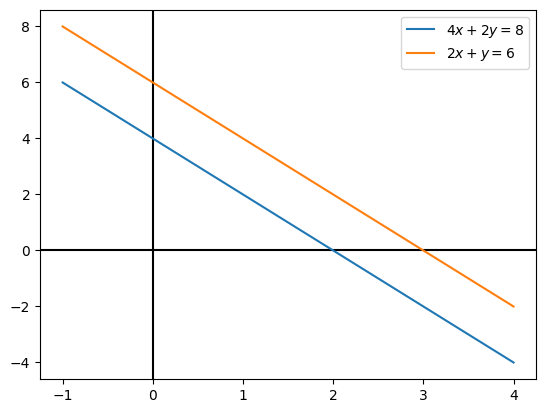

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    return (8 - 4 * x) / 2

def f2(x):
    return (6 - 2 * x)

fs = [f1, f2]
fn_names = [r"$ 4x + 2y = 8 $", r"$ 2x + y = 6 $"]
xs = np.linspace(-1, 4)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
for i, f in enumerate([f1, f2]):
    ys = [f(x) for x in xs]
    plt.plot(xs, ys, label=fn_names[i])

ax.legend()
plt.show()

A pair of parallel lines will never intersect, and therefore, we won't be able to find a solution for the system of linear equations represented by those lines.

The following picture illustrates the situation in which we have the same straight line defined by two different equations:

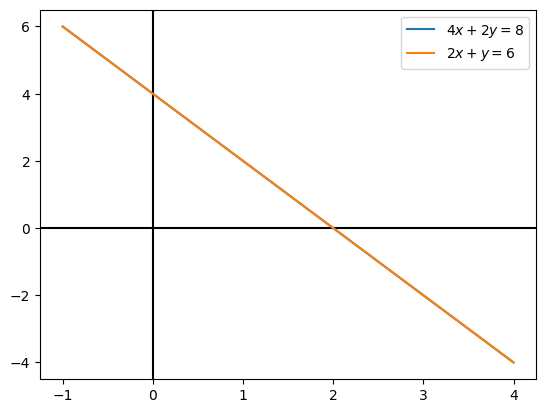

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    return (8 - 4 * x) / 2

def f2(x):
    return (4 - 2 * x)

fs = [f1, f2]
fn_names = [r"$ 4x + 2y = 8 $", r"$ 2x + y = 6 $"]
xs = np.linspace(-1, 4)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
for f, fn_name in zip(fs, fn_names):
    ys = [f(x) for x in xs]
    plt.plot(xs, ys, label=fn_name)

ax.legend()
plt.show()

In this case there are infinitely many intersections points &mdash; every point along the line is an intersection point.

Those situations are computationally problematic, and NumPy will complain:

In [5]:
import numpy as np

# No solution
m = np.array(
    (
        (4, 2),
        (2, 1)
    )
)

c = np.array((8, 6))

try:
    np.linalg.solve(m, c)
except np.linalg.LinAlgError as e:
    print(f"Oops! {e}")

Oops! Singular matrix


In [6]:
import numpy as np

# No solution
m = np.array(
    (
        (4, 2),
        (2, 1)
    )
)

c = np.array((8, 4))

try:
    np.linalg.solve(m, c)
except np.linalg.LinAlgError as e:
    print(f"Oops! {e}")

Oops! Singular matrix


The matrices:

$
\begin{pmatrix}
2 & 1 \\
4 & 2 \\
\end{pmatrix}
$

and

$
\begin{pmatrix}
4 & 4 \\
2 & 1 \\
\end{pmatrix}
$

are called *singular matrices*, meaning there is no unique solution to the linear system.

While the system of linear equations is defined by a matrix $ A $ and a vector $ \vec{w} $, the matrix on its own is enough to tell us whether the lines are parallel and whether the system has a unique solution.

The key is realizing that the rows and columns on both matrices are linearly dependent, and therefore parallel.

In relation to our Asteroids game implementation, we just need to modify our `do_segments_intersect` implementation to take care of the `np.linalg.LinAlgError`. When that happens, it's either because the laser beam and the asteroid segment are parallel, or the same line, so we can safely swallow the exception and return False.

```python
def do_segments_intersect(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, y2, v1, v2)
        return (
          distance(u1, (x, y) <= d1) and
          distance(u2, (x, y) <= d1) and
          distance(v1, (x, y) <= d2) and
          distance(v2, (x, y) <= d2)
        )
    except np.linalg.LinAlgError:
      return False
```

### Exercise

It's possible that $ \vec{u} + t \cdot \vec{v} $ can be a line through the origin. In this case, what you can you say about $ \vec{u} $ and $ \vec{v} $?

If $ \vec{u} + t \cdot \vec{v} $ passes through the origin $ (0, 0) $, it means $ \vec{u} + t \cdot \vec{v}  = (0, 0) $ for some $ t $.

Let $ u = (u_x, u_y) $, $ v = (v_x, v_y) $.

$
(u_x, u_y) + t \cdot (v_x, v_y) = (0, 0) \\
(u_x, u_y) - (0, 0) = -t \cdot (v_x, v_y) \\
(u_x, u_y) = k \cdot (v_x, v_y)
$

Therefore, $ \vec{u} $ and $ \vec{v} $ are scalar multiples.

Obviously, it can also happen that $ \vec{u} $ = (0, 0) $.

### Exercise

If $ \vec{v} = \vec{0} = (0, 0) $, do points of the form $ \vec{u} + t \cdot \vec{v} $? represent a line?

If $ \vec{v} = (0, 0) $, the parametric formula is:

$
\vec{r}(t) = \vec{u} + t \cdot (0, 0)
$

Thus, for any $ t $, $ \vec{r}(t) = \vec{u}  $ which is a single point.

### Exercise

It turns out that the formula $ \vec{u} + t \cdot \vec{v} $ is not unique; that is, you can pick different values of $ \vec{u} $ and $ \vec{v} $ to represent the same line.

What is another line representing $ (2, 2) + t \cdot (-1, 3) $?

The straight line need to pass through $ (2, 2) $, therefore, that vector needs to stay the same, but for $ \vec{v} $, we can pick any scalar multiple of $ (-1, 3) $, for example, $ (-2, 6) $:

Thus, if we choose $ (2, 2) + t \cdot (-2, 6) $:

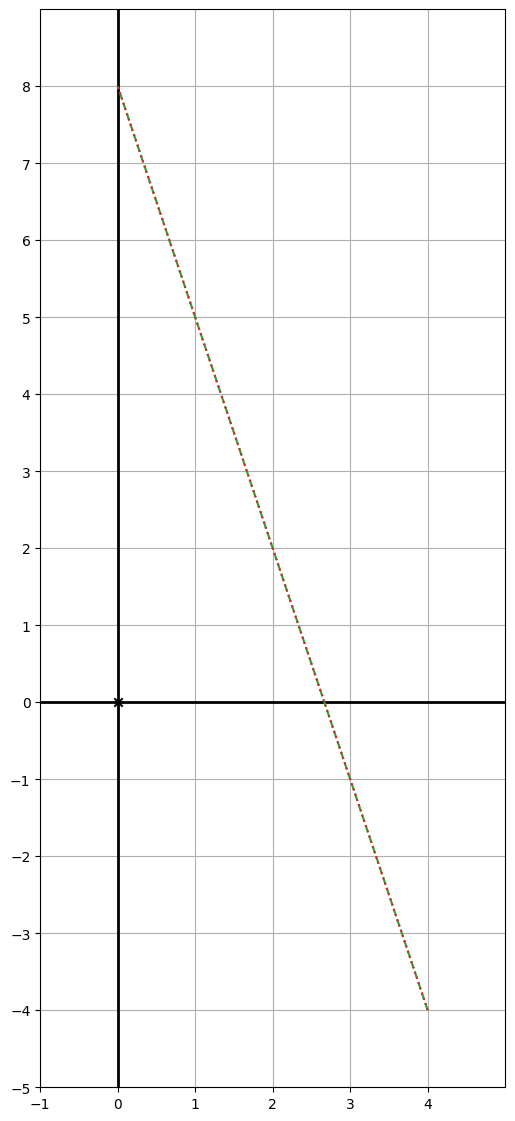

In [12]:
from vec2d.graph import Segment, Arrow, Colors, Points, draw, LineStyles
from vec2d.math import add, scale

u_1 = (2, 2)
v_1 = (-1, 3)

u_2 = (2, 2)
v_2 = (-2, 6)

draw(
    Segment(add(u_1, scale(-2, v_1)), add(u_1, scale(2, v_1)), color=Colors.GREEN, linestyle=LineStyles.DASHED),
    Segment(add(u_2, scale(-1, v_2)), add(u_2, scale(1, v_2)), color=Colors.RED, linestyle=LineStyles.DOTTED)
)

Looking at the picture above, you can also see that you can replace $ \vec{u} $ with any other point along the line.

For example, for t = 1, $ (2, 2) + (-1, 3) = (1, 5) $.

Therefore, $ (1, 5) + t \cdot (-1, 3) $ is also another formula for the same straight line:

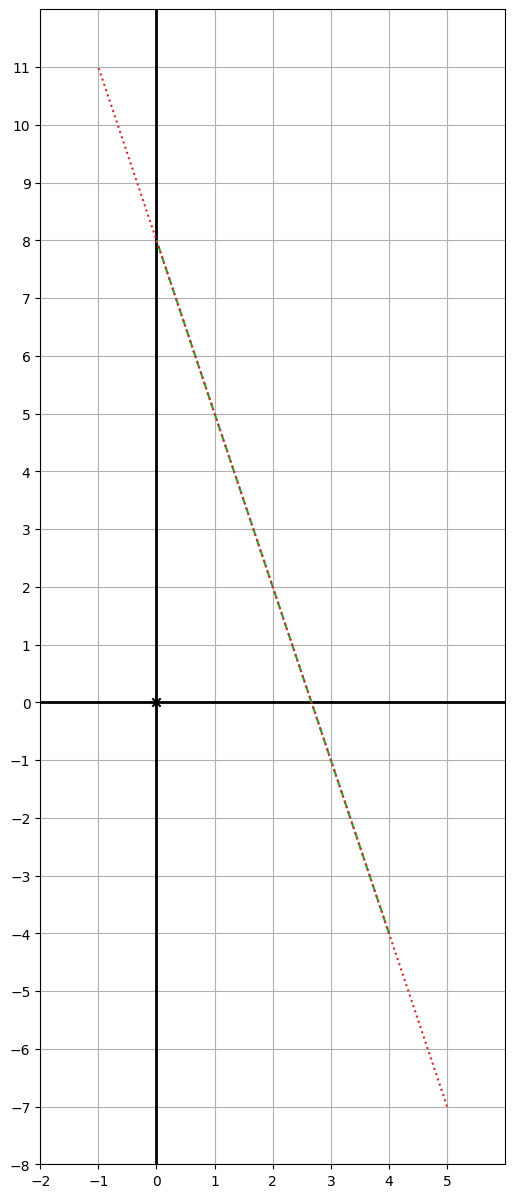

In [15]:
from vec2d.graph import Segment, Arrow, Colors, Points, draw, LineStyles
from vec2d.math import add, scale

u_1 = (2, 2)
v_1 = (-1, 3)

u_2 = (1, 5)
v_2 = (-2, 6)

draw(
    Segment(add(u_1, scale(-2, v_1)), add(u_1, scale(2, v_1)), color=Colors.GREEN, linestyle=LineStyles.DASHED),
    Segment(add(u_2, scale(-2, v_2)), add(u_2, scale(1, v_2)), color=Colors.RED, linestyle=LineStyles.DOTTED)
)

### Exercise

Does $ a \cdot x + b \cdot y = c $ represent a line for any values of $ a $, $ b $, and $ c $?

If $ a $ and $ b $ are $ 0 $, we end up with $ c = 0 $, which doesn't represent a line. If  $ c $ is cero this would always be true, and if $ c $ is different from zero it would never be true.

In any case, it doesn't establish any relationship between $ x $ and $ y $ and therefore, it would not describe a line.

### Exercise

Find another equation for the line $ 2x + y = 3 $, showing that the choices of $ a $, $ b $, and $ c $ are not unique.

The equation $ 2x + y = 3 $ establishes a relationship between $ x $ and $ y $, which is maintained if we multiply left and right hand side by the same factor.

Thus, $ 4x + 2y = 6 $ is another equation for the same line as can be seen below:

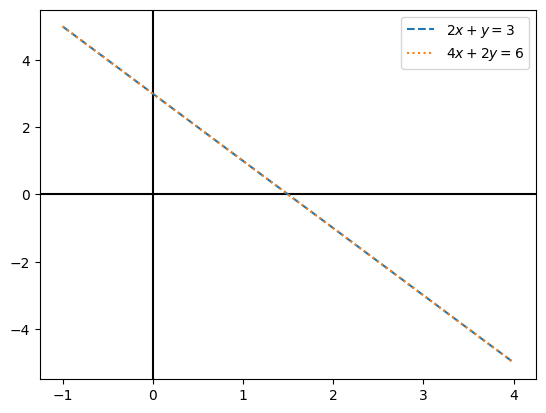

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    return (3 - 2 * x)

def f2(x):
    return (6 - 4 * x) / 2


linestyles = ["dashed", "dotted"]
fs = [f1, f2]
fn_names = [r"$ 2x + y = 3 $", r"$ 4x + 2y = 6 $"]
xs = np.linspace(-1, 4)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
for i, f in enumerate([f1, f2]):
    ys = [f(x) for x in xs]
    plt.plot(xs, ys, label=fn_names[i], linestyle=linestyles[i])

ax.legend()
plt.show()

### Exercise

The equation $ ax + by = c $ is equivalent to an equation involving a dot product of two 2D vectors $ (a, b) \cdot (x, y) = c $. You could then say that a line is a set of vectors whose dot product with a given vector is constant. What is the geometric interpretation of this statement?

We know that the dot product is a way in which we can multiply two vectors and get a scalar as a result.

We also know, that the result of the dot product let us understand how any two given vectors are aligned:
+ Two vectors that are relatively aligned give a positive dot product. The larger the vectors, the larger the product.
+ Two vectors pointing in opposite or near opposite direction have a negative product. The bigger the magnitude of the vectors, the more negative their dot product.
+ Two vectors pointing in exactly perpendicular directions will have zero as their dot product.

We also saw that the behavior explained aboved resembled the behavior of the cosine, which ranges from -1 to 1, with:
+ $ cos(0°) = 1 $
+ $ cos(90°) = 0 $
+ $ cos(180°) = -1 $
+ $ cos(270°) = 0 $

Finally, we know that the dot product can be written in two ways:
+ $ \vec{u} \cdot \vec{v} = (u_x, u_y) \cdot (v_x, v_y) = u_x v_x + u_y v_y $
+ $ \vec{u} \cdot \vec{v} = | \vec{u}| \cdot | \vec{v} | \cdot cos(\theta) $

Therefore, when we say: $ (a, b) \cdot (x, y) = c $, we mean finding the set of vectors $ (x, y) $ which happen to have a constant dot product.

Let's develop our intuition with an example:

$
2x + y = 4
$

The vectors: $ (1, 2) $, $ (0, 4) $, and $ (2, 0) $ all fall in the line.

In [21]:

from vec3d.math import dot

u = (2, 1)
assert dot(u, (1, 2)) == 4
dot(u, (0, 4)) == 4
dot(u, (2, 0)) == 4

True

Because the dot product stays constant, if $ (x, y) $ is a point along the line, we know that:

$ (a, b) \cdot (x, y) = c $

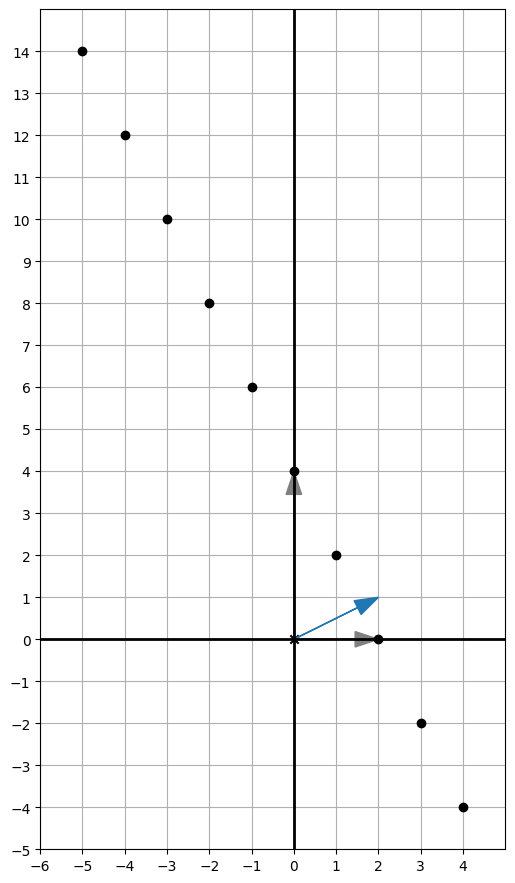

In [2]:
from vec2d.graph import draw, Points, Arrow, Colors

draw(
    Arrow((2, 1), color=Colors.BLUE),
    Arrow((0, 4), color=Colors.GRAY),
    Arrow((2, 0), color=Colors.GRAY),
    Points(*[(x, 4 - 2 * x) for x in range(-5, 5)])
)


However, this does not give us any useful geometric representation for $ (a, b) $ or $ c $.



Let's change the approach, and start from a geometric representation, and then we'll figure out how to get to the dot product and the standard form for the straight line.

Consider the following diagram depicting a line:

![Straight line](pics/geometric_representation.png)


Note the following elements:
+ $ (x_0, y_0) $ is a point in the line
+ $ (x, y) $ is the collection of points along the line
+ $ (a, b) $ is a vector perpendicular to the line

It happens that $ (a, b) $ and $ (x_0, y_0) $ uniquely defines a straight line. That is, there is a single line going through $ (x_0, y_0) $ which is perpendicular to $ (a, b) $.

Now we need to see how to describe all the points along the line ($ (x, y) $).

The points along the line are described by $ (x - x_0, y - y_0) $. Because $ (a, b) $ is perpendicular to the line we can write:

$
(a, b) \cdot (x - x_0, y - y_0) = 0 \\
a \cdot (x - x_0) + b \cdot (y - y_0) = 0 \\
a x + b y = a x_0 + b y_0
$

That happens to be equation for the line that goes through $ (x_0, y_0) $ and that is perpendicular to $ (a, b) $.

Let's see it with an example.

The following cell shows a straight line that passes through $ (3, 5) $ and is perpendicular $ (3, 2) $.

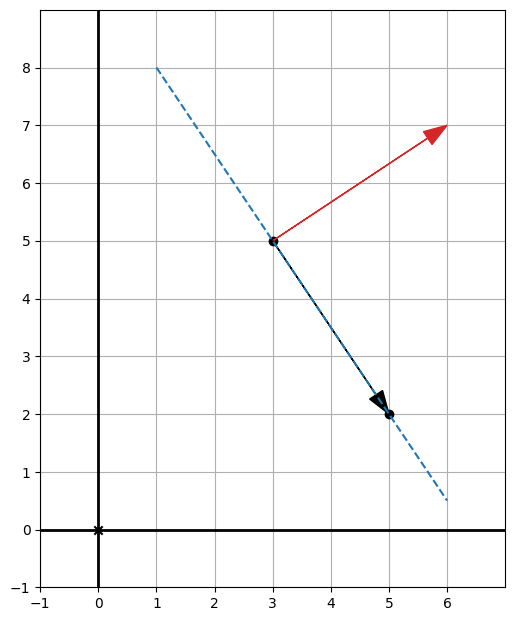

In [10]:
from vec2d.graph import draw, Arrow, Segment, Colors, LineStyles, Points
from vec2d.math import add

point = (3, 5)
ab = (3, 2)

def straight_line(point, ab, x):
    x0, y0 = point
    a, b = ab
    return (x, (a * x0 + b * y0 - a * x) / b)

draw(
    Segment(straight_line(point, ab, 1), straight_line(point, ab, 6), color=Colors.BLUE, linestyle=LineStyles.DASHED),
    Points(point),
    Arrow(add(point, ab), point, color=Colors.RED),
    Arrow(straight_line(point, ab, 5), point, color=Colors.BLACK),
    Points(straight_line(point, ab, 5)),
)


### Exercise

Confirm that the vectors $ (0, 7) $ and $ (3.5, 0) $ both satisfy the equation $ 2x + y = 7 $.

We just need to substitute:

+ $ 2 \cdot 0 + 7 = 7 $
+ $ 2 \cdot 3.5 + 0 = 7 $

Also using Python:

In [3]:
from vec3d.math import dot

assert dot((2, 1), (0, 7)) == 7
assert dot((2, 1), (3.5, 0)) == 7

### Exercise

Draw a graph for $ (3, 0) + t \cdot (0, 1) $ and convert it to the standard form using the formula.

Let's start with the first part:

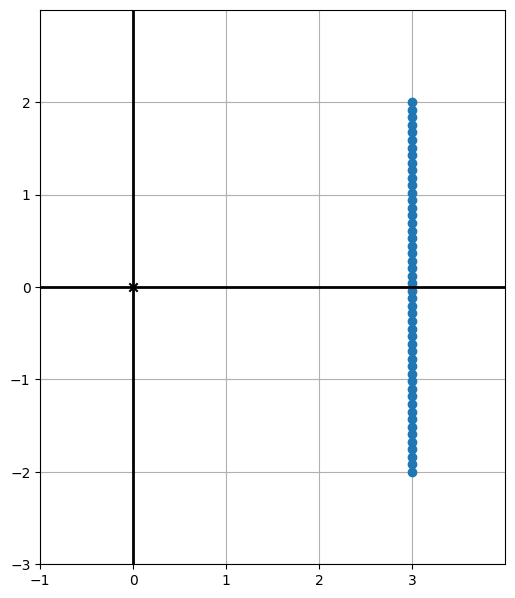

In [6]:
from vec2d.graph import draw, Points, Colors
from vec2d.math import add, scale
import numpy as np

ts = np.linspace(-2, 2)
u = (3, 0)
v = (0, 1)

draw(
    Points(*[add(u, scale(t, v)) for t in ts], color=Colors.BLUE)
)


We have a formula to get the standard form for an equation $ ax + by = c $ given two points $ (x_1, y_1) $ and $ (x_2, y_2) $ on the line:

For the parametric formula, $ (3, 0) + t \cdot (0, 1) $ we can use:
+ when $ t = 0 \rightarrow (3, 0) $
+ when $ t = 1 \rightarrow (3, 1) $

Thus, the coefficients for the standard form will be:

$
a = (y_2 - y_1) = 1 - 0 = 1 \\
b = (x_1 - x_2) = 3 - 3 = 0 \\
c = x_1 \cdot y_2 - x_2 \cdot y_1 = 3 \cdot 1 - 3 \cdot 0 = 3
$

Thus, 

$
x = 3
$


### Exercise 

Write a Python function `standard_form` that takes two vectors $ \vec{v_1} $ and $ \vec{v_2} $ and finds the line $ ax + by + c $ passing through both of them.

Specifically, the function should output the constants $ a $, $ b $, and $ c $.

In [1]:
def standard_form(p1, p2) -> tuple[float, float, float]:
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - x2 * y1
    return a, b , c

assert standard_form((3, 0), (3, 1)) == (1, 0, 3)

### Exercise

For each of the four distance checks in `do_segments_intersect`, find a pair of line segments that fail one of the checks but pass the other three checks.

Let's start by creating a version of `do_segments_intersect` called `segments_checks` that instead of resolving `True` or `False` returns the result of the checks. Then we can try with a few lines that intersect at (0, 0):

In [3]:
import numpy as np
from vec2d.math import distance

def segments_checks(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        return [
            distance(u1, (x, y)) <= d1,
            distance(u2, (x, y)) <= d1,
            distance(v1, (x, y)) <= d2,
            distance(v2, (x, y)) <= d2
        ]
    except np.linalg.LinAlgError:
        return False

def standard_form(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - x2 * y1
    return a, b, c

def intersection(u1, u2, v1, v2):
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)

segments_checks(((-3, 0), (-1, 0)), ((0, -1), (0, 1)))

[False, True, True, True]

Let's draw those segments to understand:

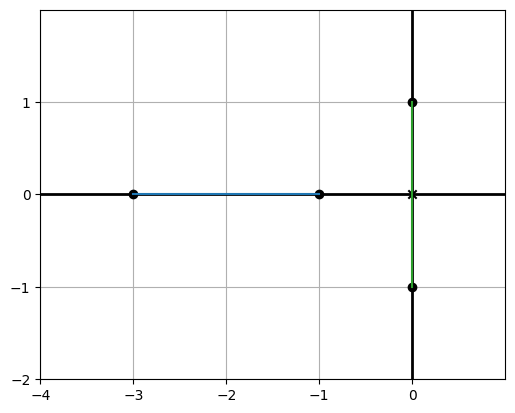

In [8]:
from vec2d.graph import draw, Segment, Colors, Points

s1 = ((-3, 0), (-1, 0))
s2 = ((0, -1), (0, 1))

draw(
    Points(*[*s1, *s2]),
    Segment(*s1, color=Colors.BLUE),
    Segment(*s2, color=Colors.GREEN)

)

Se see that the intersection point of the extension of the segments is $ (0, 0) $. That point belongs to one of the segments, which ensures that two checks will pass.

For the other two, we calculate:
+ `distance(u1=(-3, 0), (0, 0)) <= d1`, which is False
+ `distance(u2=(-1, 0), (0, 0)) <= d1`, which is True

That is, it happens that the distance between one of the points is less than the length of the segment.

If we had chosen a segment a bit further away, those two checks would've been false.

Let's confirm with for example, ((-5, 0), (-3, 0)):

In [9]:
import numpy as np
from vec2d.math import distance

def segments_checks(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        return [
            distance(u1, (x, y)) <= d1,
            distance(u2, (x, y)) <= d1,
            distance(v1, (x, y)) <= d2,
            distance(v2, (x, y)) <= d2
        ]
    except np.linalg.LinAlgError:
        return False

def standard_form(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - x2 * y1
    return a, b, c

def intersection(u1, u2, v1, v2):
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)

segments_checks(((-5, 0), (-3, 0)), ((0, -1), (0, 1)))

[False, False, True, True]

That confirms our expectations.

That interpretations gives us a way to find more segments, such as (1, 0), (10, 0):

In [10]:
import numpy as np
from vec2d.math import distance

def segments_checks(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        return [
            distance(u1, (x, y)) <= d1,
            distance(u2, (x, y)) <= d1,
            distance(v1, (x, y)) <= d2,
            distance(v2, (x, y)) <= d2
        ]
    except np.linalg.LinAlgError:
        return False

def standard_form(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - x2 * y1
    return a, b, c

def intersection(u1, u2, v1, v2):
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)

segments_checks(((1, 0), (10, 0)), ((0, -1), (0, 1)))

[True, False, True, True]

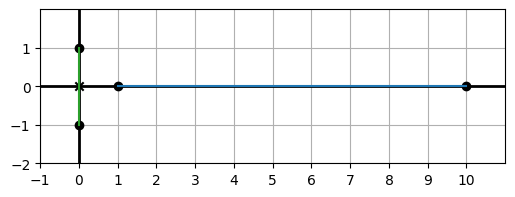

In [11]:
from vec2d.graph import draw, Segment, Colors, Points

s1 = ((1, 0), (10, 0))
s2 = ((0, -1), (0, 1))

draw(
    Points(*[*s1, *s2]),
    Segment(*s1, color=Colors.BLUE),
    Segment(*s2, color=Colors.GREEN)

)

### Exercise

For the example laser line and asteroid, confirm that the `does_intersect` function returns `True`.

![exercise: does intersect](pics/exercise_does_intersect.png)

The laser shot is defined by the segment `((0, 0), (8, 8))`.

The asteroid is defined by the points: `([(1, 5), (2, 3), (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)]`.

Let's confirm it geometrically:

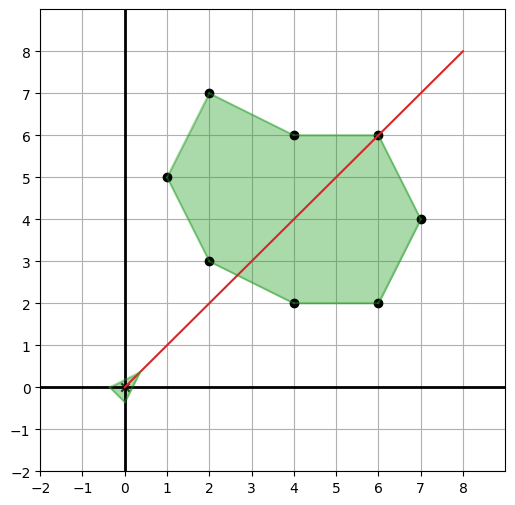

In [21]:
from math import pi
from vec2d.graph import draw, Polygon, Segment, Points, Colors
from vec2d.math import rotate

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]

draw(
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Segment((0, 0), (8, 8), color=Colors.RED),
    Polygon(*rotate(pi / 4, ship_points), color=Colors.GREEN, fill=Colors.GREEN),
    Points(*asteroid_points)
)

Looks about right.

The `does_intersect` method is as follows. We need to create an adaptation that works in isolation (without requiring the nuances of the PolygonModel class):

```python
def does_intersect(self, laser_beam_segment):
    """
    Returns True if the given segment intersects with any of the segments of
    the polygon, False otherwise
    """
    for segment in self.segments():
        if PolygonModel.do_segments_intersect(segment, laser_beam_segment):
            return True
    return False
```

Let's start with the `segments` implementation that yields each of the segments of the asteroids when called:

In [16]:
asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

def segments(polygon_points):
    for i in range(len(polygon_points)):
        yield((polygon_points[i], polygon_points[(i + 1) % len(polygon_points)]))

for i, segment in enumerate(segments(asteroid_points)):
    print(f"{i}: {segment}")


0: ((1, 5), (2, 3))
1: ((2, 3), (4, 2))
2: ((4, 2), (6, 2))
3: ((6, 2), (7, 4))
4: ((7, 4), (6, 6))
5: ((6, 6), (4, 6))
6: ((4, 6), (2, 7))
7: ((2, 7), (1, 5))


Now, let's implement the `does_intersect`:

In [19]:
laser_shot = [(0, 0), (8, 8)]

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

def does_intersect(laser_shot, asteroid_points):
    for segment in segments(asteroid_points):
        if segments_intersect(laser_shot, segment):
            print(f"Hit on segment {segment}")
            return
        else:
            print(f"Miss on segment {segment}")
    print("Miss!")


def segments(polygon_points):
    for i in range(len(polygon_points)):
        yield((polygon_points[i], polygon_points[(i + 1) % len(polygon_points)]))


def segments_intersect(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        return (
            distance(u1, (x, y)) <= d1 and
            distance(u2, (x, y)) <= d1 and
            distance(v1, (x, y)) <= d2 and
            distance(v2, (x, y)) <= d2
        )
    except np.linalg.LinAlgError:
        return False

def standard_form(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - x2 * y1
    return a, b, c

def intersection(u1, u2, v1, v2):
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)


does_intersect(laser_shot, asteroid_points)

Miss on segment ((1, 5), (2, 3))
Hit on segment ((2, 3), (4, 2))


By contrast, a shot directly up the y-axis should not hit:

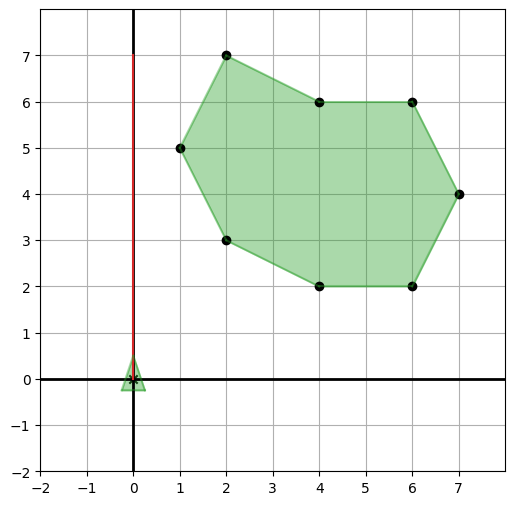

In [22]:
from math import pi
from vec2d.graph import draw, Polygon, Segment, Points, Colors
from vec2d.math import rotate

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

ship_points = [(0.5, 0), (-0.25, 0.25), (-0.25, -0.25)]

draw(
    Polygon(*asteroid_points, color=Colors.GREEN, fill=Colors.GREEN),
    Segment((0, 0), (0, 7), color=Colors.RED),
    Polygon(*rotate(pi / 2, ship_points), color=Colors.GREEN, fill=Colors.GREEN),
    Points(*asteroid_points)
)

In [23]:
laser_shot = [(0, 0), (0, 7)]

asteroid_points = [
    (1, 5), (2, 3),
    (4, 2), (6, 2), (7, 4), (6, 6), (4, 6), (2, 7)
    ]

def does_intersect(laser_shot, asteroid_points):
    for segment in segments(asteroid_points):
        if segments_intersect(laser_shot, segment):
            print(f"Hit on segment {segment}")
            return
        else:
            print(f"Miss on segment {segment}")
    print("Miss!")


def segments(polygon_points):
    for i in range(len(polygon_points)):
        yield((polygon_points[i], polygon_points[(i + 1) % len(polygon_points)]))


def segments_intersect(s1, s2):
    u1, u2 = s1
    v1, v2 = s2
    d1, d2 = distance(*s1), distance(*s2)
    try:
        x, y = intersection(u1, u2, v1, v2)
        return (
            distance(u1, (x, y)) <= d1 and
            distance(u2, (x, y)) <= d1 and
            distance(v1, (x, y)) <= d2 and
            distance(v2, (x, y)) <= d2
        )
    except np.linalg.LinAlgError:
        return False

def standard_form(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    a = y2 - y1
    b = x1 - x2
    c = x1 * y2 - x2 * y1
    return a, b, c

def intersection(u1, u2, v1, v2):
    a1, b1, c1 = standard_form(u1, u2)
    a2, b2, c2 = standard_form(v1, v2)
    m = np.array(((a1, b1), (a2, b2)))
    c = np.array((c1, c2))
    return np.linalg.solve(m, c)


does_intersect(laser_shot, asteroid_points)

Miss on segment ((1, 5), (2, 3))
Miss on segment ((2, 3), (4, 2))
Miss on segment ((4, 2), (6, 2))
Miss on segment ((6, 2), (7, 4))
Miss on segment ((7, 4), (6, 6))
Miss on segment ((6, 6), (4, 6))
Miss on segment ((4, 6), (2, 7))
Miss on segment ((2, 7), (1, 5))
Miss!


### Exercise

Write a `does_collide(other_polygon)` to decide whether the current `PolygonModel` object collides with another polygon by checking whether any of the segments that define the two are intersecting.

This could help us decide whether an asteroid has hit the ship or another asteroid.

The function is implemented in [Asteroids: step 3](../../02_mini-projects/17-asteroids_base-collision/).

```python
def does_collide(self, other_polygon):
    """
    Returns true if any of the segments of the polygon intersects with any
    of the segments of the other polygon given.
    """
    for segment in other_polygon.segments():
        if self.does_intersect(segment):
            return True
    return False
```

Note that it is a very naive way of checking collisions, as if an asteroid is within another asteroid it won't return True.

### Exercise

We can't pick a vector $ \vec{w} $, so that the following system has a unique solution $ \vec{v} $.

$
\begin{pmatrix}
2 & 1 \\
4 & 2 \\
\end{pmatrix} \vec{v} = \vec{w}
$

Find a vector $ \vec{w} $ such that there are infinitely many solutions to the system, that is, infinitely many values of $ v $ that satisfy the equation.

We know from the concepts section that the equation above spans a system of linear equations:

$
\begin{cases}
2x + y = c \\
4x + 2y = d \\
\end{cases}
$

If we make $ c = d = 0 $ the two equations are the same: $ 2x + y = 0 $, and therefore, the system will have infinitely many solutions.

The solutions will have the form: $ y = -2x $, so the vectors will have the form $ (a, -2 \cdot a) $.

Thus, $ (1, -2) $, $ (0, 0) $, and $ (-1, 2) $ are a few of those solutions:

## Generalizing linear equations to higher dimensions

We can represent a wide variety of problems as systems of linear equations. 

Linear equations in the wild often have more than two "unknown" variables that describe collections of points in two or more dimensions.

In more than three dimensions it's hard to picture, but we can use 3D and establish an analogy with what we know in 2D.

### Representing planes in 3D

We already saw in 2D that the equation $ ax + by = c $ is the set of points $ (x, y) $ whose dot product is a fixed number $ c $.

Thus, the equation $ ax + by = c $ is equivalent to $ (a, b) \cdot (x, y) = c $.

Let's see how to interpret this geometrically.

If we have a point and a non-zero vector in 2D there is a unique line that is perpendicular to the vector and passes through the point.

![Geometric representation of straight line](pics/geometric_representation.png)


Let's call the point $ (x_0, y_0) $ and the given vector $ (a, b) $. Let $ (x, y) $ describe the points that lie along the line.

Because $ (x, y) $ is part of the line, $ (x - x_0, y - y_0) $ will be a vector parallel to the line and perpendicular to $ (a, b) $.

The vector $ (x - x_0, y - y_0) $ is what we called the *displacement vector*, the vector that goes from $ (x, y) $ to $ (x_0, y_0) $ and that results from doing $ (x, y) - (x_0, y_0) $.

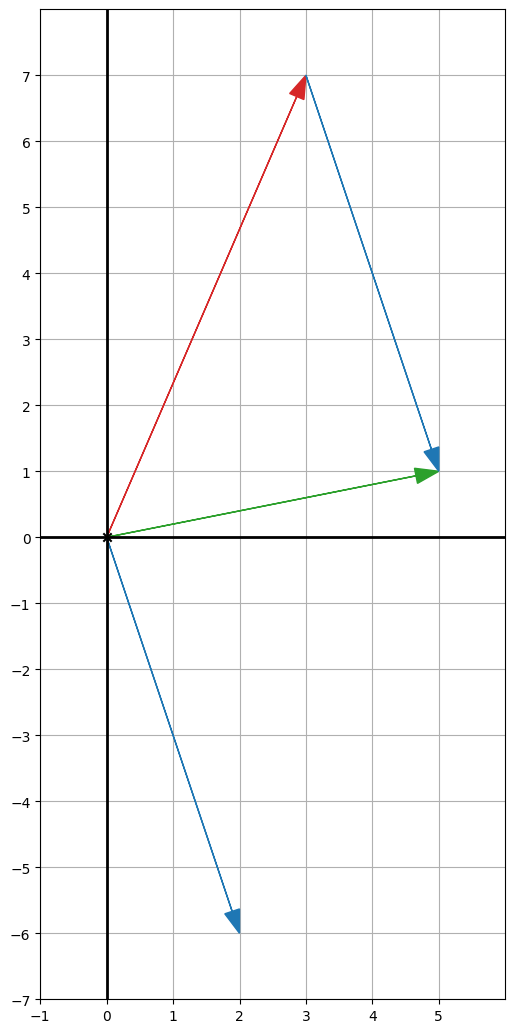

In [3]:
from vec2d.graph import Arrow, Colors, draw
from vec2d.math import add, subtract

v0 = (3, 7)
vx = (5, 1)

draw(
    Arrow(v0, color=Colors.RED),
    Arrow(vx, color=Colors.GREEN),
    Arrow(vx, v0, color=Colors.BLUE),
    Arrow(subtract(vx, v0), color=Colors.BLUE),
)



We also saw that the dot product ranges from:
+ the multiplication of the vector lengths when the vectors are parallel and oriented in the same direction.
+ zero when the vectors lie at a 90° (or -90°) angle, that is, when they are perpendicular.
+ minus the multiplication of the vector lengths when the vectors are parallel and oriented in different directions.

and that we could write:
$
\vec{u} \cdot \vec{v} = |u| \cdot |v| \cdot cos(\theta)
$

Because the vector $ (a, b) $ is perpendicular to the line, and the points along the line can be described by $ (x - x_0, y - y_0) $ we can write:

$
(a, b) \cdot (x - x_0, y - y_0) = 0 \\
a (x - x_0) + b (y - y_0) = 0 \\
a x + b y = a x_0 + b y_0
$

Because the term on the right-hand side is constant, it can be renamed to $ c $ and we get to the standard form $ ax + by = c $.

Thus, $ (a, b) $ is a vector perpendicular to the line, and $ (x_0, y_0) $ is a point in the line.

Thus, we can now reproduce the first picture using Python:

2024-02-23 09:04:27,077 [    INFO] (vec2d.graph.vector2d_graphics) | Using vec2d.graph v0.2.3


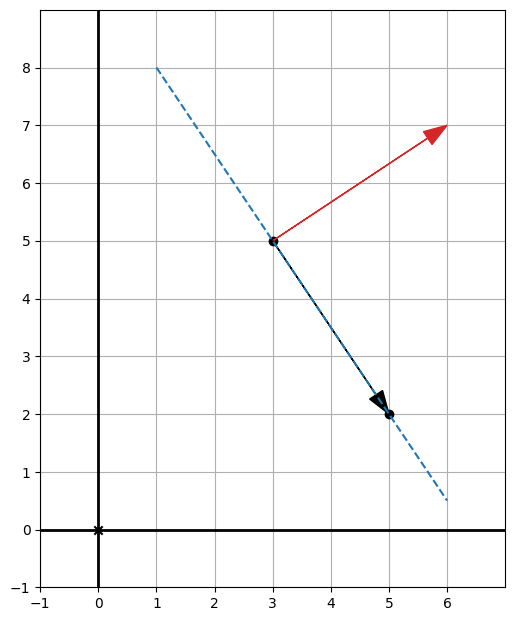

In [1]:
from vec2d.graph import draw, Arrow, Segment, Colors, LineStyles, Points
from vec2d.math import add

point = (3, 5)
ab = (3, 2)

def straight_line(point, ab, x):
    x0, y0 = point
    a, b = ab
    return (x, (a * x0 + b * y0 - a * x) / b)

draw(
    Segment(straight_line(point, ab, 1), straight_line(point, ab, 6), color=Colors.BLUE, linestyle=LineStyles.DASHED),
    Points(point),
    Arrow(add(point, ab), point, color=Colors.RED),
    Arrow(straight_line(point, ab, 5), point, color=Colors.BLACK),
    Points(straight_line(point, ab, 5)),
)


Let's generalize this idea in 3D.

Given a point and a vector in 3D there is a unique plane perpendicular to the vector and passing through that point.

![Geometric representation: plane](pics/geometric_representation_plane.png)



Let's denote the vector as $ (a, b, c) $, and the point in the plane $ (x_0, y_0, z_0) $. The points in the plane will have coordinates $ (x, y, z) $.

Using the same reasoning as in 2D:

$
(a, b, c) \cdot (x - x_0, y - y_0, z - z_0) = 0
$

Because the vectors whose tails are $ (x_0, y_0, z_0) $ and tip are $ (x, y, z) $ can be written as $ (x - x_0, y - y_0, z - z_0) $ and are perpendicular to $ (a, b c) $.

Thus:
$
a x + b y + c z = a x_0 + b y_0 + c z_0
$

Now, we can draw that with our libraries:

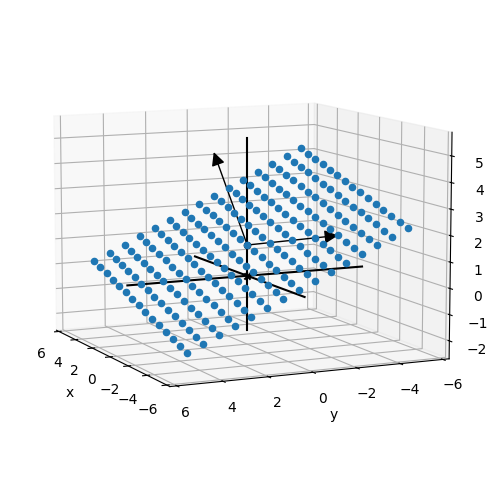

In [3]:
import numpy as np
from vec3d.graph import draw3d, Colors3D, Points3D, Arrow3D


plane_point = (0, 0, 1.2)
perpendicular_v = (-1, 2, 5)


def get_plane_points_fn(perpendicular_v, plane_point):
    a, b, c = perpendicular_v
    x0, y0, z0 = plane_point
    def new_fn(x, y):
        return (x, y, (a * x0 + b * y0 + c * z0 - a * x - b * y) / c)
    return new_fn

plane_fn = get_plane_points_fn(perpendicular_v, plane_point)
xs = np.linspace(-5, 5, 15)
ys = np.linspace(-5, 5, 15)

draw3d(
    Points3D(plane_point),
    Points3D(*[plane_fn(x, y) for x in xs for y in ys], color=Colors3D.BLUE),
    Arrow3D(plane_fn(xs[3], ys[3]), plane_point, color=Colors3D.BLACK),
    Arrow3D(perpendicular_v, plane_point, color=Colors3D.BLACK),
    elev=9,
    azim=155,
)

### Solving linear equations in 3D

A pair of non-parallel lines in the 2D plane intersects at exactly one point.

In the 3D space, if we draw a pair of intersecting planes we can see that they intersect along a line &mdash; there's an infinite number of points where two non-parallel planes intersect.

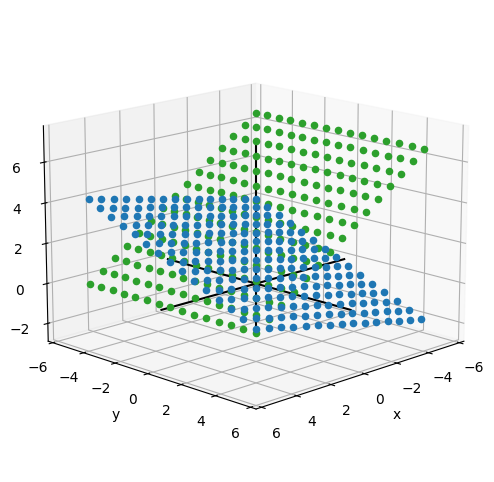

In [2]:
import numpy as np
from vec3d.graph import draw3d, Colors3D, Points3D, Arrow3D


plane1_point = (0, 0, 1.2)
perpendicular1_v = (-1, 2, 5)

plane2_point = (2, 2, 2)
perpendicular2_v = (2, 0, 3)


def get_plane_points_fn(perpendicular_v, plane_point):
    a, b, c = perpendicular_v
    x0, y0, z0 = plane_point
    def new_fn(x, y):
        return (x, y, (a * x0 + b * y0 + c * z0 - a * x - b * y) / c)
    return new_fn

plane1_fn = get_plane_points_fn(perpendicular1_v, plane1_point)
plane2_fn = get_plane_points_fn(perpendicular2_v, plane2_point)
xs = np.linspace(-5, 5, 15)
ys = np.linspace(-5, 5, 15)

draw3d(
    Points3D(*[plane1_fn(x, y) for x in xs for y in ys], color=Colors3D.BLUE),
    Points3D(*[plane2_fn(x, y) for x in xs for y in ys], color=Colors3D.GREEN),
    elev=15,
    azim=45,
)

If you then add a third plane that is not parallel to this intersection line, you can find a unique intersection point:

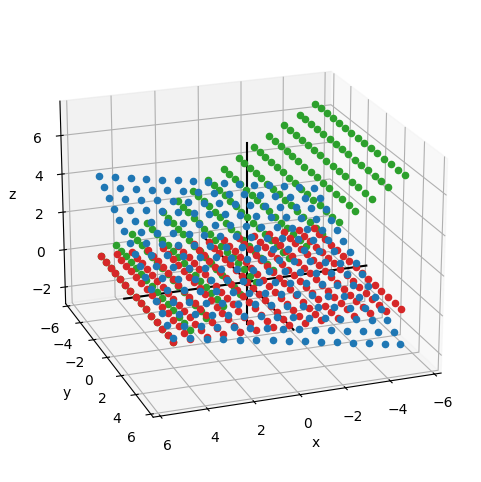

In [4]:
import numpy as np
from vec3d.graph import draw3d, Colors3D, Points3D, Arrow3D


plane1_point = (0, 0, 1.2)
perpendicular1_v = (-1, 2, 5)

plane2_point = (2, 2, 2)
perpendicular2_v = (2, 0, 3)

plane3_point = (0, 0, 0)
perpendicular3_v = (0, 0, 1)

def get_plane_points_fn(perpendicular_v, plane_point):
    a, b, c = perpendicular_v
    x0, y0, z0 = plane_point
    def new_fn(x, y):
        return (x, y, (a * x0 + b * y0 + c * z0 - a * x - b * y) / c)
    return new_fn

plane1_fn = get_plane_points_fn(perpendicular1_v, plane1_point)
plane2_fn = get_plane_points_fn(perpendicular2_v, plane2_point)
plane3_fn = get_plane_points_fn(perpendicular3_v, plane3_point)

xs = np.linspace(-5, 5, 15)
ys = np.linspace(-5, 5, 15)

draw3d(
    Points3D(*[plane1_fn(x, y) for x in xs for y in ys], color=Colors3D.BLUE),
    Points3D(*[plane2_fn(x, y) for x in xs for y in ys], color=Colors3D.GREEN),
    Points3D(*[plane3_fn(x, y) for x in xs for y in ys], color=Colors3D.RED),
    elev=21,
    azim=70,
)

Finding this point algebraically requires finding a common solution to three linear equations in three variables, each representing one of the planes:

$
\begin{cases}
a_1x + b_1y + c_1z = d_1 \\
a_2x + b_2y + c_2z = d_2 \\
a_3x + b_3y + c_3z = d_3 \\
\end{cases}
$

We can convert the system of linear equations into a matrix equation:

$
\begin{pmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{pmatrix} \begin{pmatrix}
x \\
y \\
z \\
\end{pmatrix} = \begin{pmatrix}
d_1 \\
d_2 \\
d_3 \\
\end{pmatrix}
$

Let's see with an example:

$
\begin{cases}
x + y - z = -1 \\
2y - z = 3 \\
x + z = 2
\end{cases}
$

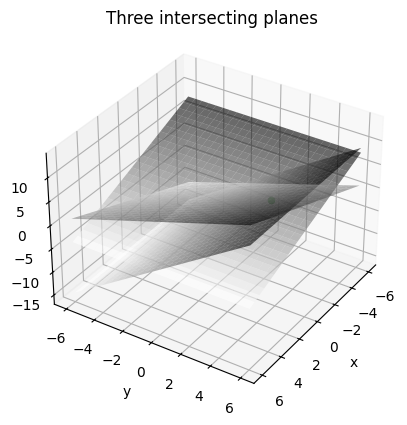

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

def plane_1(x, y):
    return x + y + 1

def plane_2(x, y):
    return 2 * y - 3

def plane_3(x, y):
    return 2 - x

xs = np.linspace(-6, 6, 25)
ys = np.linspace(-6, 6, 25)

planes = [plane_1, plane_2, plane_3]

fig = plt.figure()
ax = plt.axes(projection="3d")

for plane in planes:
    X, Y = np.meshgrid(xs, ys)
    Z = plane(X, Y)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="binary", edgecolor="none", alpha=0.6),

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Three intersecting planes")
ax.view_init(33, 33)

It's not easy to see, but the three planes do intersect in a single point.

We can find that point using NumPy as we did with the systems of linear equations in 2D:

$
\begin{cases}
x + y - z = -1 \\
2y - z = 3 \\
x + z = 2
\end{cases}
$

In [1]:
import numpy as np

matrix = np.array(
    (
        (1, 1, -1),
        (0, 2, -1),
        (1, 0, 1)
    )
)

vector = np.array((-1, 3, 2))

np.linalg.solve(matrix, vector)

array([-1.,  3.,  3.])

Thus, the point $ (-1, 3, 3) $ is the solution of the system of linear equations, and geometrically, the point where the three planes intersect.

Note that while this was easy to compute, it's harder to visualize:

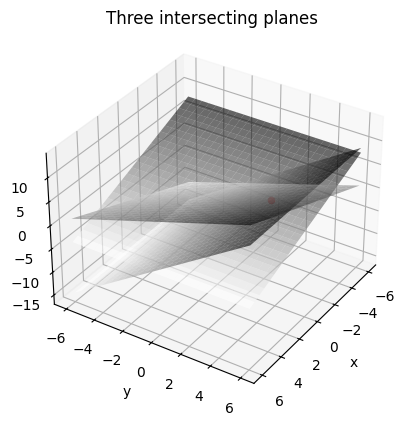

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d

def plane_1(x, y):
    return x + y + 1

def plane_2(x, y):
    return 2 * y - 3

def plane_3(x, y):
    return 2 - x

xs = np.linspace(-6, 6, 25)
ys = np.linspace(-6, 6, 25)

planes = [plane_1, plane_2, plane_3]

fig = plt.figure()
ax = plt.axes(projection="3d")

for plane in planes:
    X, Y = np.meshgrid(xs, ys)
    Z = plane(X, Y)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="binary", edgecolor="none", alpha=0.6),

ax.scatter3D(-1, 3, 3, color="red")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Three intersecting planes")
ax.view_init(33, 33)

Or using our vec3d library:

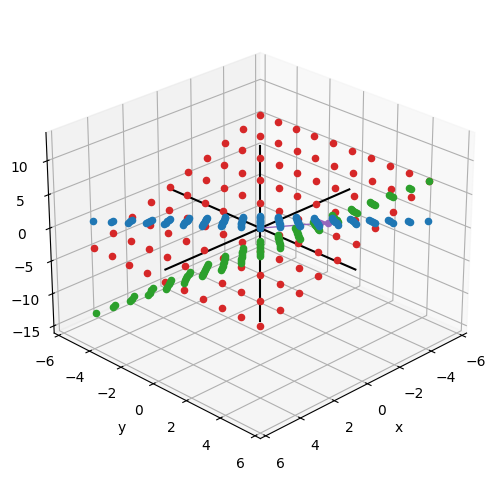

In [13]:
import numpy as np
from vec3d.graph import draw3d, Colors3D, Points3D, Arrow3D


def plane_1(x, y):
    return (x, y, x + y + 1)

def plane_2(x, y):
    return (x, y, 2 * y - 3)

def plane_3(x, y):
    return (x, y, 2 - x)

xs = np.linspace(-5, 5, 10)
ys = np.linspace(-5, 5, 10)

draw3d(
    Points3D(*[plane_1(x, y) for x in xs for y in ys], color=Colors3D.BLUE),
    Points3D(*[plane_2(x, y) for x in xs for y in ys], color=Colors3D.GREEN),
    Points3D(*[plane_3(x, y) for x in xs for y in ys], color=Colors3D.RED),
    Points3D((-1, 3, 3), color=Colors3D.PURPLE),
    Arrow3D((-1, 3, 3), color=Colors3D.PURPLE),
    elev=26,
    azim=45,
)

### Studying hyperplanes algebraically

Beyond 3D, it's impossible to visualize linear systems, but solving them is mechanically the same.

The analogy to a line or a plane in any number of dimensions is called a hyperplane, and the problem boils down to finding the points where multiple hyperplanes intersect.

To be precise, a hyperplane in $ n $ dimensions is a solution to a linear equation in $ n $ unknown variable:
+ a line is a 1D hyperplane living in the 2D plane.
+ a plane is a 2D hyperplane living in the 3D space.
+ ...

A linear equation in standard form in 4D has the form:

$
a w + bx + cy + dz = e
$

The set of solutions $ (w, x, y, z) $ form a region that is a 3D hyperplane living in the 4D space.

It's quite common to write linear equations in standard form doing:

$
a_1 x_1 + a_2 x_2 + a_3 x_3 + a_4 x_4 = b
$

where $ (a_1, a_2, a_3, a_4) $ are the coefficients and the set of vectors that satisfy the equation are $ (x_1, x_2, x_3, x_4) $.

We could just as easily write a linear equation in 10 dimensions:

$
a_1 x_1 + a_2 x_2 + a_3 x_3 + a_4 x_ 4 + a_5 x _5 + a_6 x_6 + a_7 x_7 + a_8 x_8 + a_9 x_9 + a_{10} x_{10} = b
$

This can also be written with an ellipsis:

$
a_1 x_1 + a_2 x_2 + a_3 x_3 + \ldots + a_{10} x_{10} = b
$

or more formally with the summation symbol Σ:

$
\displaystyle \sum_{i=1}^{10} a_i x_i = b
$

To represent a system of $ m $ linear equations in $ n $ dimensions we can write:

$
\begin{cases}
a_{11} x_1 + a_{12} x_2 + \ldots + a_{1n} x_n = b_1 \\
a_{21} x_1 + a_{22} x_2 + \ldots + a_{2n} x_n = b_2 \\
\ldots \\
a_{m1} x_1 + a_{m2} x_2 + \ldots + a_{mn} x_n = b_m \\
\end{cases}
$

This can be more compactly written in matrix form:

$
\begin{bmatrix}
a_{11} & a_{12} & \ldots & a_{1n} \\
a_{21} & a_{22} & \ldots & a_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{m1} & a_{m2} & \ldots & a_{mn} \\
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_n \\
\end{bmatrix} = \begin{bmatrix}
b_1 \\
b_2 \\
\vdots \\
b_m \\
\end{bmatrix}
$

### Counting dimensions, equations, and solutions

In 2D, a pair of lines intersect at a single point (if they're not parallel). In algebraic terms, we can say that a system of two linear equations in two variables can have a unique solution.

In 3D, three planes can intersect at a single point. This is not always the case, but three is the minimum number of planes (or linear equations) required to specify a point in 3D (and therefore a unique solution to the system of linear equations representing the planes).

With only two planes, you have at least a 1D space of possible solutions, which is the line in which they might intersect.

In general:
> you need $ n $ linear equations to be able to get a unique solution in $ n $ dimensions.

Let's consider an example in 4D, with the coordinates $ (x_1, x_2, x_3, x_4) $. Let's take our first linear equation to be $ x_4 = 0 $. The solutions to this linear equation form a 3D hyperplane, consisting of the vectors of the form $ (x_1, x_2, x_3, 0) $. This is a 3D space of solutions, and it turns out to be a vector subspace of $ \mathbb{R^4} $ with basis $ \{ (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) \} $

Consider now a second linear equation $ x_2 = 0 $. The solutions to this equation on its own are also a 3D hyperplane consisting of the vectors of the form $ (x_1, 0, x_3, x_4) $.

The intersection of these 3D hyperplanes is a 2D space consisting of vectors of the form $ (x_1, 0, x_3, 0) $. If we could picture it, we would see it as a 2D plane living in 4D space. Specifically, it is the plane spanned by $ (1, 0, 0, 0) $ and $ (0, 0, 1, 0) $.

If we now add one more linear equation $ x_1 = 0 $, which in its own also defines a hyperplane in the form $ (0, x_2, x_3, x_4) $, renders a 1D space of solutions. The vectors in this 1D space line on a line in 4D and have the form $ (0, 0, x_3, 0) $, which is exactly the $ x_3 $-axis, a 1D subspace of $ \mathbb{R^4} $, with basis $ (0, 0, 1, 0) $.

If we finally impose a fourth linear equation $ x_3 = 0 $, the only possible solution will be $ (0, 0, 0, 0) $, a zero-dimensional vector space.

Each time we add an equation, we reduced the dimension of the solution space by one, until we got a zero-dimensional space consisting of a single point.

However, had we chose different equations, each step would not have been as clear; we would have to test whether each successive hyperplane truly reduces the dimension of the solution space by one or not (as it happens in 2D when we add a second equation that happens to be parallel to the first one).

For example, if we started with $ x_1 = 0 $ and $ x_2 = 0 $, and then added a third equation $ x_1 + x_2 = 0 $, the third equation will not reduce the dimension of the solution space beacuse $ x_1 $ and $ x_2 $ are already constrained to zero.

More generally, we can say:
> if you're working in $ n $ dimensions, the lowest dimensional space you can get with $ m $ linear equations is $ n - m $. If that is the case, we call the system of linear equations *independent*.

Independent directions in a space are sometimes called *degrees of freedom*. Every independent linear equation that we introduce in a system of linear equations is a constraint that reduces the space of solutions to a smaller number of dimensions. When the number of independent degrees of freedom (dimensions) equals the number of independent constraints (linear equations), there are no longer any degrees of freedom, and we're left with a unique point.

### Exercise
What is the equation for a line that passes through $ (5, 4) $ and is perpendicular to $ (-3, 3) $.

We saw that if we have a point in the line and a perpendicular vector to it we can write the equation for the line in standard form as $ \vec{v} \cdot (x - x_0, y - y_0) = 0 $

$
(-3, 3) \cdot (x - 5, y - 4) = 0 \\
-3 (x - 5) + 3 (y - 4) = 0 \\
-3x + 3y = -3 \\
-x + y = -1
$

Let's confirm geometrically:

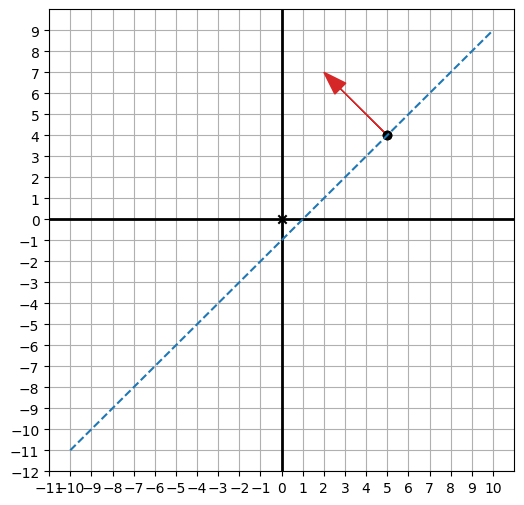

In [4]:
from vec2d.graph import draw, Arrow, Segment, Colors, LineStyles, Points
from vec2d.math import add

point = (5, 4)
ab = (-3, 3)

def straight_line(point, ab, x):
    x0, y0 = point
    a, b = ab
    return (x, (a * x0 + b * y0 - a * x) / b)

draw(
    Segment(straight_line(point, ab, -10), straight_line(point, ab, 10), color=Colors.BLUE, linestyle=LineStyles.DASHED),
    Points(point),
    Arrow(add(point, ab), point, color=Colors.RED),
    Arrow(straight_line(point, ab, 5), point, color=Colors.BLACK),
    Points(straight_line(point, ab, 5)),
)


### Exercise

Consider a system of two linear equations in 4D:

$
\begin{cases}
x_1 + 2 x_2 + 2 x_3 + x_4 = 0 \\
x_1 - x_4 = 0
\end{cases}
$

Explain algebraically (rather than geometrically) why the solutions form a vector subspace of 4D.

Let's recall first how we can algebraically confirm that a collection of vectors is a vector subspace.

Vector spaces are collection of objects that behave like vectors, in this case, the collection of solutions of a system of two linear equations in four dimensions.

We know that the key operations in a vector space are vector addition and scalar multiplication. With these we can make linear combinations that define additional operations such as negation, subtraction, weighted averages, etc.

We saw that for a collection vectors to be a vector space it had to comply with the following six rules:

1. $ \vec{u} + \vec{v} = \vec{v} + \vec{u} $
2. $ \vec{u} + (\vec{v} + \vec{w}) = (\vec{u} + \vec{v}) + \vec{w} $
3. $ a \cdot (b \cdot \vec{u}) = (a \cdot b) \cdot \vec{u} $
4. $ 1 \cdot \vec{u} = \vec{u} $
5. $ a \cdot \vec{u} + b \cdot \vec{u} = (a + b) \cdot \vec{u} $
6. $ a \cdot (\vec{u} + \vec{v}) = a \cdot \vec{u} + b \cdot \vec{v} $

Note that most of these rules are immediate for $ \mathbb{R^4} $, so when dealing with subsets of $ \mathbb{R^4} $ that we need to confirm if they're vector spaces, it is sufficient to confirm that every linear combination of vectors in that subset produces a vector that is also in the collection.

That is the process we're going to follow. Given two solutions to the system of linear equations:

$
\begin{cases}
x_1 + 2 x_2 + 2 x_3 + x_4 = 0 \\
x_1 - x_4 = 0 \\
\end{cases}
$

denoted as $ (a_1, a_2, a_3, a_4) $ and $ (b_1, b_2, b_3, b_4) $, and two scalars $ c $, and $ d $, we need to confirm that:

$
c \cdot (a_1, a_2, a_3, a_4) + d \cdot (b_1, b_2, b_3, b_4)
$

is also a solution.

Let's compute the linear combination first:

$
c \cdot (a_1, a_2, a_3, a_4) + d \cdot (b_1, b_2, b_3, b_4) \\
= (c \cdot a_1 + d \cdot b_1, c \cdot a_2 + d \cdot b_2, c \cdot a_3 + d \cdot b_3, c \cdot a_4 + d \cdot b_4)
$

Now we can check if that linear combination satisfies the equations.

Starting with the first equation:

$
x_1 + 2x_2 + 2x_3 + x_4 = 0
$

We have:

$
c \cdot a_1 + d \cdot b_1 + 2 \cdot (c \cdot a_2 + d \cdot b_2) + 2 \cdot (c \cdot a_3 + d \cdot b_3) + c \cdot a_4 + d \cdot b_4 \\
= c \cdot a_1 + d \cdot b_1 + 2 \cdot c \cdot a_2 + 2 \cdot d \cdot b_2 + 2 \cdot c \cdot a_3 + 2 \cdot d \cdot b_3 + c \cdot a_4 + d \cdot b_4
$

If we reorganize it a little bit:

$
c \cdot a_1 + 2 \cdot c a_2 + 2 \cdot c a_3 + c \cdot a_4 + d \cdot b_1 + 2 \cdot d b_2 + 2 \cdot d b_3 + d \cdot b_4 \\
= c \cdot (a_1 + 2 a_2 + 2 a_3 + a_4) + d \cdot (b_1 + 2 b_2 + 2 b_3 + b_4) \\
$

But because $ (a_1, a_2, a_3, a_4) $ and $ (b_1, b_2, b_3, b_4) $ are solutions of the system of linear eqautions:

$
\begin{cases}
(a_1 + 2 a_2 + 2 a_3 + a_4) = 0 \\
(b_1 + 2 b_2 + 2 b_3 + b_4) = 0 \\
\end{cases}
$

And therefore $ c \cdot (a_1, a_2, a_3, a_4) + d \cdot (b_1, b_2, b_3, b_4) $ is a solution for the first equation.

Now, let's apply the same procedure for the second:

$
x_1 - x_4 = 0
$

Which means:

$
c a_1 + d b_1 - (c a_4 + d b_4) \\
= c a_1 + d b_1 - c a_4 - d b_4 \\
= c \cdot (a_1 - a_4) + d \cdot (b_1 - b_4)
$

But because $ (a_1, a_2, a_3, a_4) $ and $ (b_1, b_2, b_3, b_4) $ are solutions of the system of linear eqautions:

$
\begin{cases}
(a_1 - a_4) = 0 \\
(b_1 - b_4) = 0 \\
\end{cases}
$

and therefore $ c \cdot (a_1, a_2, a_3, a_4) + d \cdot (b_1, b_2, b_3, b_4) $ is a solution for the second equation.

As a consequence, if $ (a_1, a_2, a_3, a_4) $ and $ (b_1, b_2, b_3, b_4) $ are solutions of the system of linear equations, then a linear combination of both, $ c \cdot (a_1, a_2, a_3, a_4) + d \cdot (b_1, b_2, b_3, b_4) $ is also a solution, and therefore, the solutions to the system of linear equations form a vector subspace of $ \mathbb{R^4} $.

### Exercise

What is the standard form equation for a plane that passes through the point $ (1, 1, 1) $ and is perpendicular to the vector $ (1, 1, 1) $.



We can apply the same procedure we use for the line that passes through a point and is perpendicular to a given vector:

Let $ \vec{u} = (1, 1, 1) $ and $ p = (1, 1, 1) $.

Then, the points in the plane can be written as $ (x - p_x, y - p_y, z - p_z) $

$
\vec{u} \cdot (x - p_x, y - p_y, z - p_z) = 0 \\
(1, 1, 1) \cdot (x - 1, y - 1, z - 1) = 0 \\
(x - 1) + (y - 1) + (z - 1) = 0 \\
x + y + z = 3
$

Let's plot it with our vec2d library first:

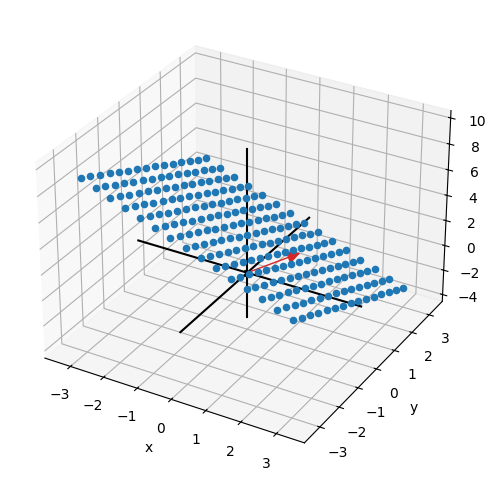

In [5]:
import numpy as np
from vec3d.graph import Arrow3D, Points3D, draw3d, Colors3D

xs = np.linspace(-3, 3, 15)
ys = np.linspace(-3, 3, 15)

def plane_points(x, y):
    return (x, y, 3 - x - y)

draw3d(
    Arrow3D((1, 1, 1), color=Colors3D.RED),
    Points3D(*[plane_points(x, y) for x in xs for y in ys], color=Colors3D.BLUE)

)

### Exercise

Write a Python function that takes three 3D points as inputs and returns the standard form equation of the plane that they lie in.

For instance, if the standard form equation is $ ax + by + cz = d $, the function should return $ (a, b, c, d) $.

We know that to get the solution, the simplest way would be to write the plane equation in a matrix form and then apply NumPy's linalg solver.

Let $ u = (u_{x}, u_{y}, u_{z}) $, $ v = (v_{x}, v_{y}, v_{z}) $, and $ w = (w_{x}, w_{y}, w_{wz}) $, being three vectors pointing to three points in the plane.

Because differences of any pairs of those three vectors will be parallel to the plane, the cross products of the differences will be perpendicular.

That is:

+ $ (w - u) $ and $ (v - u) $ are parallel to the plane
+ $ (w - u) \times (v - u) $ is perpendicular to the plane.
+ We know from the previous exercise how to find the equation of the plane given a vector perpendicular to the plane and a point in the plane: $ perpvec \cdot (x - u_x, y - u_y, z - u_z) = 0 $. 

Now, we can apply Python:

In [6]:
from vec3d.math import subtract, cross, dot
from vec3d.graph import draw3d, Points3D, Colors3D

def plane_equation(u, v, w):
    parallel_vector_1 = subtract(v, u)
    parallel_vector_2 = subtract(w, u)
    a, b, c = cross(parallel_vector_1, parallel_vector_2)
    d = dot((a, b, c), u)
    return (a, b, c, d)


p1 = (1, 1, 1)
p2 = (3, 0, 0)
p3 = (0, 3, 0)

plane_equation(p1, p2, p3)



(3, 3, 3, 9)

### Exercise

How many total constants $ a_{ij} $ are in the following matrix equation? How many equations are there? How many unknowns? Write the full matrix equation and the full system of linear equations.

$
\begin{pmatrix}
a_{11} & a_{12} & \ldots & a_{17} \\
a_{21} & a_{22} & \ldots & a_{27} \\
\vdots & \vdots & \ddots & \vdots \\
a_{51} & a_{52} & \ldots & a_{57} \\
\end{pmatrix} \begin{pmatrix}
x_1 \\
x_2 \\
\vdots \\
x_7 \\
\end{pmatrix} = \begin{pmatrix}
b_1 \\
b_2 \\
\vdots \\
b_5 \\
\end{pmatrix}
$

+ There are $ 7 \times 5 = 35 $ total constants.
+ There are 5 rows, and therefore, 5 equations.
+ There are 7 unknowns.

The full matrix equation is:

$
\begin{pmatrix}
a_{11} & a_{12} & a_{13} & a_{14} & a_{15} & a_{16} & a_{17} \\
a_{21} & a_{22} & a_{23} & a_{24} & a_{25} & a_{26} & a_{27} \\
a_{31} & a_{32} & a_{33} & a_{34} & a_{35} & a_{36} & a_{37} \\
a_{41} & a_{42} & a_{43} & a_{44} & a_{45} & a_{46} & a_{47} \\
a_{51} & a_{52} & a_{53} & a_{54} & a_{55} & a_{56} & a_{57} \\
\end{pmatrix} \begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
x_6 \\
x_7 \\
\end{pmatrix} = \begin{pmatrix}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5 \\
\end{pmatrix}
$


And the full system of linear equation is:

$
\begin{cases}
a_{11} \; x_1 + a_{12} \; x_2 + a_{13} \; x_3 + a_{14} \; x_4 + a_{15} \; x_5 + a_{16} \; x_6 + a_{17} \; x_7 = b_1 \\
a_{21} \; x_1 + a_{22} \; x_2 + a_{23} \; x_3 + a_{24} \; x_4 + a_{25} \; x_5 + a_{26} \; x_6 + a_{27} \; x_7 = b_2 \\
a_{31} \; x_1 + a_{32} \; x_2 + a_{33} \; x_3 + a_{34} \; x_4 + a_{35} \; x_5 + a_{36} \; x_6 + a_{37} \; x_7 = b_3 \\
a_{41} \; x_1 + a_{42} \; x_2 + a_{43} \; x_3 + a_{44} \; x_4 + a_{45} \; x_5 + a_{46} \; x_6 + a_{47} \; x_7 = b_4 \\
a_{51} \; x_1 + a_{52} \; x_2 + a_{53} \; x_3 + a_{54} \; x_4 + a_{55} \; x_5 + a_{56} \; x_6 + a_{57} \; x_7 = b_5 \\
\end{cases}
$

### Exercise

Write the following linear equation without summation syntax. Geometrically, what does the set of solutions look like?

$
\displaystyle \sum^{3}_{i=1} x_i = 1
$

The summation can be expanded as:

$
x_1 + x_2 + x_3 = 1
$

The solution to that equation is a plane in the 3D space.

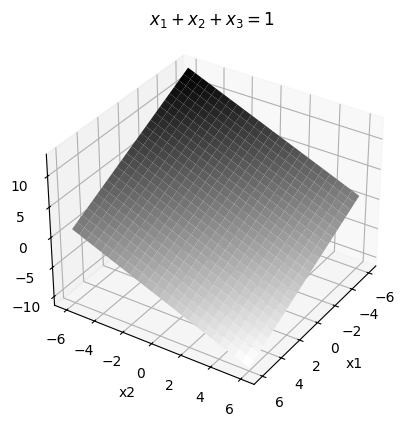

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# from mpl_toolkits import mplot3d

def equation(x1, x2):
    return 1 - x1 - x2

xs = np.linspace(-6, 6, 25)
ys = np.linspace(-6, 6, 25)


fig = plt.figure()
ax = plt.axes(projection="3d")

X, Y = np.meshgrid(xs, ys)
Z = equation(X, Y)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="binary", edgecolor="none")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_title(r"$ x_1 + x_2 + x_3 = 1 $")
ax.view_init(33, 33)

### Exercise

Find three planes, none of which are parallel, and do not have a single point of intersection (that is, they intersect in whole lines).

### Exercise

Suppose we have $ m $ linear equations and $ n $ unknown variables. What do the following values of $ m $ and $ n $ say about whether there is a unique solution?

1. $ m = 2 $, $ n = 2 $
2. $ m = 2 $, $ n = 7 $
3. $ m = 5 $, $ n = 5 $
4. $ m = 3 $, $ n = 2 $

1. If $ m = 2 $, $ n = 2 $, there can be a unique solution as the number of equations is equal to the number of unknowns. This will happen if the equations are independent.

2. If $ m = 2 $, $ n = 7 $, we would need 5 more equations to have a unique solution. There would be a 5D hyperplane of solutions.

3. If $ m = 5 $, $ n = 5 $, there can be unique solution provided that the 5 equations are independent.

4. If $ m = 3 $, $ n = 2 $, there are more equations than unknowns. Therefore, there can be a unique solution provided that the third equation (which represents a line in the 2D plane) passes through the solution of the system of linear equations defined by the first two equations.

The example below illustrates how this can happen.

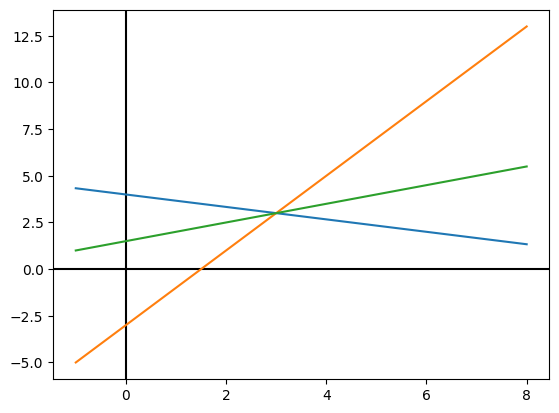

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def line_std_form(p1, p2):
    """
    Return coefficients for ax + by = c line given two points on the line
    """
    x_1, y_1 = p1
    x_2, y_2 = p2
    a = y_2 - y_1
    b = x_1 - x_2
    c = x_1 * y_2 - x_2 * y_1
    return a, b, c

def fn_solve_for_y(a, b, c):
    if b == 0:
        raise ValueError("b cannot be 0")
    def new_fn(x):
        return (c - a * x) / b
    return new_fn

line_std_form(intersection_point, (6, 2))
f1 = fn_solve_for_y(*line_std_form(intersection_point, (6, 2)))
f2 = fn_solve_for_y(*line_std_form(intersection_point, (5, 7)))
f3 = fn_solve_for_y(*line_std_form(intersection_point, (7, 5)))

fns = [f1, f2, f3]

xs = np.linspace(-1, 8)
_, ax = plt.subplots()
ax.axhline(y=0, color="k")
ax.axvline(x=0, color="k")
for f in fns:
    ys = [f(x) for x in xs]
    plt.plot(xs, ys)


plt.show()


## Exercise

Find 3 planes whose intersection is a single point, 3 planes whose intersection is a line, and 3 planes whose intersection is a plane.